# Ham Vs Spam Classification
---

## List of Imports

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
from bs4 import BeautifulSoup
import os
import re
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer, word_tokenize, WordPunctTokenizer
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, recall_score, \
                                precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from mygraphs import histogram_top_n_words





## Globals

In [141]:
# Globals used throughout the project
#==================================================================================================

# seaborn darkgrid style
sns.set_style('darkgrid')

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# List of email paths to load
email_paths = ['Data//easy_ham_1', 
               'Data//easy_ham_2', 
               'Data//hard_ham_1', 
               'Data//hard_ham_2', 
               'Data//spam_1', 
               'Data//spam_2']

# Regex patterns to match multi-line text block searches
block_regex_list = ['^(?!Subject:)[A-Z]\\S*:'] # Pattern to match any line that starts with a capital letter followed by a word and a colon

# Regex patterns to match whole line searches
line_regex_list = [
    r'From\s+.*@.*',                                       
    r'[A-Z].*?-.*?:',                                       
    r'^[A-Z].*?@.*?:',
    r'^--',                     # Pattern to match any line that starts with --
    r'^[\w\.-]+@[\w\.-]+',      # Pattern to match any line that starts with an email address
    r'^http',                   # Pattern to match any line that starts with https
    r'^.{0,9}http',             # Pattern to match any line that has http within the first 10 characters
    r'^\s*tests=.*',            # Pattern to match any line that starts with any number of whitespace then tests= then anything afterwards
    r'^\s*version=.*',          # Pattern to match any line that starts with any number of whitespace then version=
    r'^___.*',                  # Pattern to match any line that starts with ___
    r'.*[A-Z]+_[A-Z]+_.*',      # Pattern to match any line that has 3 or more words in all caps separated by _
    r'.*============.*',        # Pattern to match any line that has ============ in it
    r'.*------------.*'         # Pattern to match any line that has ------------ in it
]

# Regex patterns to match single expresion searches
single_regex_list = ['>', # Pattern to match any line that starts with >
                     r'\[\d\]', # Pattern to match any line that has a number in square brackets
                     r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', # Pattern to match any email address
                     r'www\.', # Pattern to match any line that starts with www.
                     r'http\.'
]



## Maximum False-Pos Rate Custom Classifier Class
- It is very important to minimize false positives (customers Ham going to their Spam folders and potentially missing important communication)
- Due to this business case, we are capping the models at 1% false positive rate
- Defined below is a custom classifier class to be used in pipelines to tune the thresholds of the models such that we can target a maximum false positive rate
- Additionally, we will be scoring Precision as our main metric, and scoring Accuracy secondarily

In [142]:
# Create a custom classifier that adjusts the threshold to achieve a target false positive rate
class ThresholdAdjuster(BaseEstimator):
    def __init__(self, base_estimator, max_fpr=0.15):
        '''
        Parameters: base_estimator - a trained model
                    max_fpr - the target false positive rate
        '''
        self.base_estimator = base_estimator
        self.max_fpr = max_fpr
        self.threshold_calculated = False

    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        if not self.threshold_calculated:
            self.adjust_threshold_for_fpr(X, y)
        return self
    
    def predict(self, X):
        probabilities = self.base_estimator.predict_proba(X)
        return (probabilities[:, 1] > self.threshold).astype(int)
    
    def predict_proba(self, X):
        return self.base_estimator.predict_proba(X)
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
        
    def adjust_threshold_for_fpr(self, X, y_true, verbose=False):
        '''
        Parameters: X - a matrix of features
                    y_true - the true labels
        Returns: None

        Adjusts the threshold of the model to achieve a target false positive rate
        '''
        verbose = True
        # get the predicted probabilities
        y_test_prob = self.predict_proba(X)[:, 1]
        threshold = 0
        fpr = 1
        # loop until the false positive rate is less than target_fpr
        while fpr > self.max_fpr:
            # increase the threshold
            threshold += 0.001
            # get the predicted values
            y_pred = (y_test_prob > threshold).astype(int)     
            # calculate the false positive rate
            cm = confusion_matrix(y_true, y_pred)
            fpr = cm[0, 1] / cm[0].sum()
        if verbose:
            print(f'Threshold: {threshold:.3f}, FPR: {fpr:.3f}')
        self.threshold = threshold
        self.threshold_calculated = True
   

## Create a report function to be used on all models
- also stores the model names, model and results in a dictionary for final evaluations

In [143]:
# define a data frame to store the results of the models
model_results_df = pd.DataFrame(columns=['Model Name', 'Data Set', 'Best Estimator', 'Recall', 'F1', 'AUC', 'Train Accuracy', 'Accuracy', 'Precision'])

def display_results(model_name, data_name, pipeline, X_train, y_train, X_test, y_test):
    '''
    Parameters: model_name - the name of the model
                pipeline - the trained pipeline
                X_train - the training features
                y_train - the training labels
                X_test - the test features
                y_test - the test labels
    Returns: None

    Displays the results of the model
    '''
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    #cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    auc = roc_auc_score(y_test, y_test_pred)
    # add the results to the data frame; if the 'Model Name' and 'Data Set' already exist, update the values
    if model_results_df[(model_results_df['Model Name'] == model_name) & (model_results_df['Data Set'] == data_name)].shape[0] > 0:
        model_results_df.loc[(model_results_df['Model Name'] == model_name) & (model_results_df['Data Set'] == data_name), 
                                ['Recall', 'F1', 'AUC', 'Train Accuracy', 'Accuracy', 'Precision']] = [recall, f1, auc, train_accuracy, accuracy, precision]
    else:
        model_results_df.loc[len(model_results_df)] = [model_name, data_name, pipeline, recall, f1, auc, train_accuracy, accuracy, precision]

    # display the results
    print(f'Model: {model_name}')
    print('='*50)
    print(f'                 Recall: {recall:.4f}')
    print(f'                     F1: {f1:.4f}')
    print(f'                    AUC: {auc:.4f}')
    print(f'         Train Accuracy: {train_accuracy:.4f}')
    print(f'               Accuracy: {accuracy:.4f}')
    print(f'              Precision: {precision:.4f}')
    print('='*50)
    print(classification_report(y_test, y_test_pred))
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])
    disp.plot()
    plt.grid(False)
    # add a title to the confusion matrix
    plt.title(f'{model_name} Confusion Matrix')
    
    # Create the ROC curve plot for both the training and test data
    y_test_prob = pipeline.predict_proba(X_test)[:, 1]
    y_train_prob = pipeline.predict_proba(X_train)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    plt.figure(figsize=(6, 5.5))
    plt.plot(fpr_test, tpr_test, label='Test Data')
    plt.plot(fpr_train, tpr_train, label='Train Data')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    
# return the model results data frame sorted by data set then precision
def get_sorted_results():
    # remove the best estimator column for display purposes
    return model_results_df.drop(columns='Best Estimator').sort_values(by=['Data Set', 'Precision'], ascending=[True, False])
    
def show_corr_heatmap(df, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title(title)
    plt.show()


---

## Load in the Email Data from Individual HTML Files

### Helper functions used during the importing and initial cleaning of email files

In [144]:
def load_emails(path_list):
    '''
    Parameters: path_list - a list of paths to the email files
    Returns: a list of strings, each string is the content of an email file
             a list of integers, each integer is the target of an email file
                (1 for spam, 0 for not spam)

    Load the content of each email file in path_list in HTML format, 
    and return a list of strings
    '''
    emails = []
    target = []
    # loop through all the files in the folder
    for path in path_list:
        for file in os.listdir(path):
            # open the file
            with open(path + '//' + file, 'r') as f:
                # try to read the file
                try:
                    data = f.read()
                    # check if the email is spam or not
                    if 'spam' in path:
                        target.append(1)
                    else:
                        target.append(0)
                except UnicodeDecodeError:
                    continue
                # parse the file
                soup = BeautifulSoup(data, 'html.parser')
                # extract the text
                emails.append(soup.get_text())
    return emails, target


In [145]:
def strip_block(text, keyword_list):
    '''
    Parameters: text - a string of text
                keyword_list - a list of regular expressions
    Returns: a string of text with blocks of text removed

    Removes a line of from text that starts with keyword and each subsequent line 
    that starts with whitespace. This is useful for removing email headers.
    '''

    # initialize a flag to keep track of whether we are inside a block
    inside = False
    # split the text into lines
    lines = text.split('\n')
    # initialize a new list to hold the lines we want to keep
    new_lines = []
    # loop through the lines
    for line in lines:
        # check if the matches any keyword or we inside a block
        for keyword in keyword_list:
            if re.match(keyword, line) or (inside and re.match(r'^\s+', line)):
                inside = True
                break
            else:   # if we aren't, add it to the new list
                new_lines.append(line)
                inside = False

    # join the new lines together with a newline character
    return '\n'.join(new_lines)



In [146]:
def strip_line(text, keyword_list):
    '''
    Parameters: text - a string of text
                keyword_list - a list of regular expressions
    Returns: a string of text with lines of text removed

    Removes lines of from text that contains a keyword anywhere in the line
    '''
    # Split the text into lines
    text = text.split('\n')
    # Remove any lines that contain a keyword
    text = [line for line in text if not any(re.match(pattern, line) for pattern in keyword_list)]
    # Join the lines back together
    text = '\n'.join(text)
    return text

In [147]:
def strip_expression(text, keyword_list):
    '''
    Parameters: text - a string of text
                keyword_list - a list of regular expressions
    Returns: a string of text with expressions removed

    Removes expressions from text that matches the regex patterns in keyword_list
    '''


    for exp in keyword_list:
        # strip the occurance that matches the regex patterns in strip_list
        text = re.sub(exp, '', text)
    return text

In [148]:
def clean_raw_email(text, block_regex_list, line_regex_list, single_regex_list):
    '''
    Parameters: text - a string of text
                block_regex_list - a list of regular expressions
                line_regex_list - a list of regular expressions
                single_regex_list - a list of regular expressions
    Returns: a string of text with blocks, lines and expressions removed

    Removes blocks, lines and expressions from text that matches the regex patterns in block_regex_list, line_regex_list and single_regex_list
    '''
    text = strip_block(text, block_regex_list)
    text = strip_line(text, line_regex_list)
    text = strip_expression(text, single_regex_list)
    return text

In [149]:
def pop_subject(text):
    '''
    Parameters: text - a string of text (email)
    Returns: the text with the subject removed as a string
              the subject as a string
    '''
    # split the text into lines
    lines = text.split('\n')
    # initialize the subject string (in case we don't find it)
    subject = ''
    # find the first line that starts with 'Subject:'
    for i, line in enumerate(lines):
        if line.startswith('Subject:'):
            subject = line
            break
    # remove the subject from the text
    text = '\n'.join(lines[i+1:])
    # remove the 'Subject:' from the subject string
    subject = subject.replace('Subject:', '')
    return text, subject

In [150]:
def create_email_df(email_paths):
    '''
    Parameters: email_paths - a list of paths to the email files
    Returns: a DataFrame with the email body, subject and target as columns

    Load the content of each email file in email_paths in HTML format,
    clean the emails by removing blocks, lines and expressions that match 
    the regex patterns in block_regex_list, line_regex_list and single_regex_list
    and return a DataFrame with the emails and targets in random order
    '''
    emails, target = load_emails(email_paths)
    emails_cleaned = [clean_raw_email(email, block_regex_list, line_regex_list, single_regex_list) for email in emails]
    body, subject = [], []
    for email in emails_cleaned:
        body_, subject_ = pop_subject(email)
        body.append(body_)
        subject.append(subject_)
    body_df = pd.DataFrame(body, columns=['body'])
    subject_df = pd.DataFrame(subject, columns=['subject'])
    target_df = pd.DataFrame(target, columns=['target'])
    raw_df = pd.concat([subject_df, body_df,target_df], axis=1)
    raw_df = raw_df.sample(frac=1, random_state=42).reset_index(drop=True)
    return raw_df

### Load the email data into a dataframe, preliminary EDA and cleaning

In [151]:
emails_df = create_email_df(email_paths)

In [152]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5825 entries, 0 to 5824
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  5825 non-null   object
 1   body     5825 non-null   object
 2   target   5825 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 136.6+ KB


ANALYSIS
- There are no NaN

In [153]:
# Check for emails with empty subject and body
emails_df[(emails_df['subject'] == '') & (emails_df['body'] == '')].count()

subject    109
body       109
target     109
dtype: int64

ANALYSIS:
- There are 109 rows that have empty strings for both the subject and body, lets get rid of them

In [154]:
emails_df = emails_df[(emails_df['subject'] != '') | (emails_df['body'] != '')]
# reset the index
emails_df = emails_df.reset_index(drop=True)

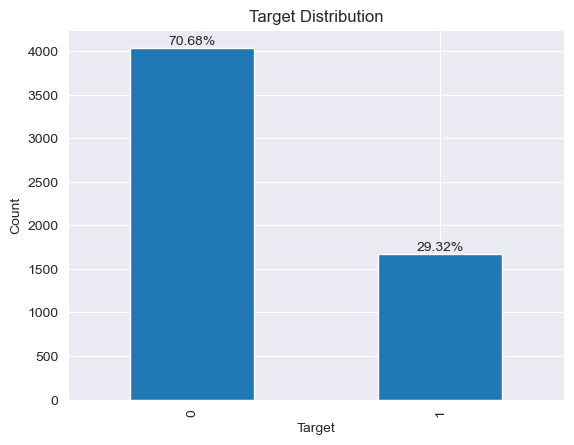

In [155]:
# Check the target distribution
emails_df['target'].value_counts()

# create a bargraph of the target distribution
emails_df['target'].value_counts().plot(kind='bar')

# add title and labels
plt.title('Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')

# add percentages to the bars
for i, count in enumerate(emails_df['target'].value_counts()):
    plt.text(i, count, f'{count/len(emails_df)*100:.2f}%', ha='center', va='bottom')

# show the plot
plt.show()

ANALYSIS:
- The target class distribution is not even, will have to deal with this during modeling

In [156]:
# Create separate dataframes for the subject and body so they can be analyzed and modeled separately
subject_df = emails_df.drop('body', axis=1)
body_df = emails_df.drop('subject', axis=1)

---

## Email-Subject


### Cleaning and EDA

In [157]:
# Create a copy of the subject dataframe for EDA
subject_eda_df = subject_df.copy()

# Lowercase the subject column
subject_eda_df['subject'] = subject_eda_df['subject'].apply(lambda x: str.lower(x))

# Tokenize the subject column
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
subject_eda_df['subject_tokenized'] = subject_eda_df['subject'].apply(lambda x: tokenizer.tokenize(x))


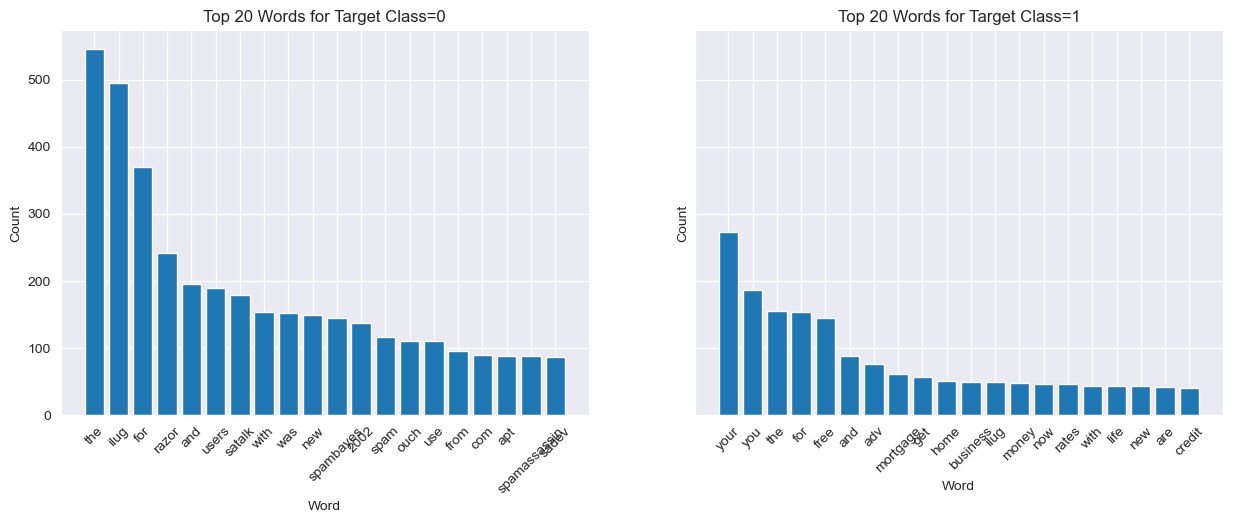

In [158]:
# visualize the top 20 words in the subject column for spam and not spam
histogram_top_n_words(subject_eda_df, 20, 'subject_tokenized', 'target')

ANALYSYS:
- Very strong signal on 're'; will need to consider removing re to simulate a more realistic spam situation as this might make it too easy
- The ham emails seem to be inter-company and many subject lines contain jargon words like spambayes (they were most likely testing thier spam filters), razor, etc.  We should also consider removing these to simulate a more realistic filtering situation in the wild.

In [159]:
# Remove stopwords and cheating words from the tokenized subject column
def remove_stopwords(token_list, stopwords_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    return [token for token in token_list if token not in stopwords_list]

cheat_words = ['re', 'razor', 'spamassassin', 'spam', 'assassin', 'spambayes', 'satalk', 'ilug', 'zzzzteana']    
stop_words = stopwords.words('english')
for word in cheat_words:
    stop_words.append(word)

subject_eda_df['subject_tokenized'] = subject_eda_df['subject_tokenized'].apply(lambda x: remove_stopwords(x, stop_words))
               

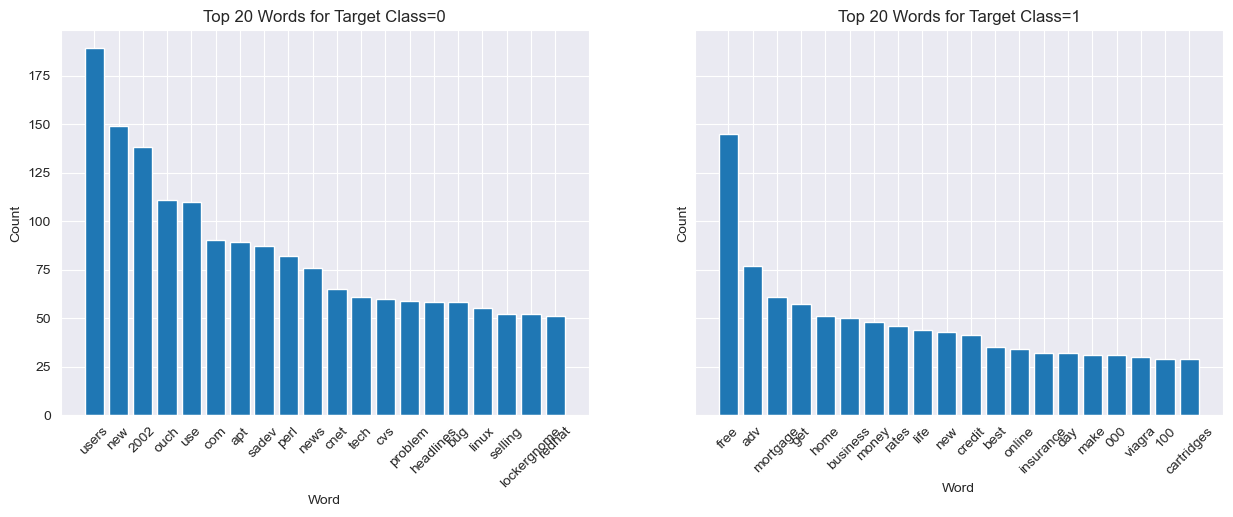

In [160]:
# visualize the top 20 words in the subject with stopwords and cheating words removed
histogram_top_n_words(subject_eda_df, 20, 'subject_tokenized', 'target')

ANALYSIS:
- Looks a little more realistic. We will run the model with and without 'cheatwords'

---

---

## Preprocessing and Modeling

In [161]:
# Create our train and test sets
X = subject_df['subject']
y = subject_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---
### Baseline Model:
- Basic tokenizer of >2 characters
- Binary vectorizer
- Multinomial Bayes Classifier

In [162]:
# Define tokenizers
word_punct_tokenizer = WordPunctTokenizer()
def word_punct_tokenizer(text):
    return word_punct_tokenizer.tokenize(text)

# Define the baseline tokenizer function
regexp_tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
def regexp_tokenizer(text):
    return regexp_tokenizer.tokenize(text)

# define the stopwords to use in the vectorizer
stop_words = stopwords.words('english')

# Create the baseline basic binary CountVectorizer pipeline step tuple
step_count_vec = ('count_vec', CountVectorizer(max_features=500,
                                                min_df=2,
                                                max_df=0.95,
                                                binary=True, 
                                                stop_words=stop_words, 
                                                tokenizer=regexp_tokenizer))

# Create the baseline MultinomialNB pipeline step tuple
step_baseline_model = ('baseline_clf', MultinomialNB(fit_prior=True))

# Create and fit the pipeline for the baseline model
pipe_baseline = Pipeline([step_count_vec, step_baseline_model])

pipe_baseline.fit(X_train, y_train)

Pipeline(steps=[('count_vec',
                 CountVectorizer(binary=True, max_df=0.95, max_features=500,
                                 min_df=2,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function regexp_tokenizer at 0x000001B07C2BB040>)),
                ('baseline_clf', MultinomialNB())])

Model: MultinomialNB (Baseline Model)
                 Recall: 0.6446
                     F1: 0.7218
                    AUC: 0.7933
         Train Accuracy: 0.8782
               Accuracy: 0.8558
              Precision: 0.8199
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       812
           1       0.82      0.64      0.72       332

    accuracy                           0.86      1144
   macro avg       0.84      0.79      0.81      1144
weighted avg       0.85      0.86      0.85      1144



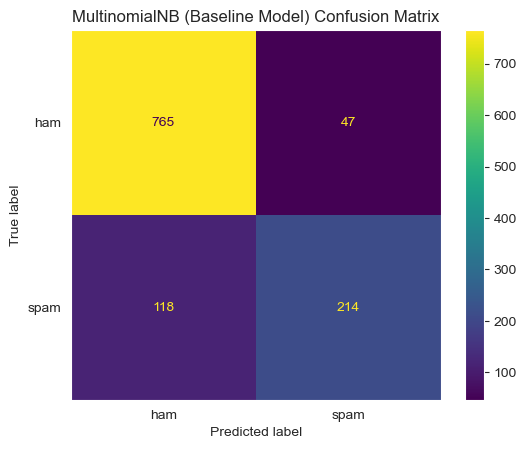

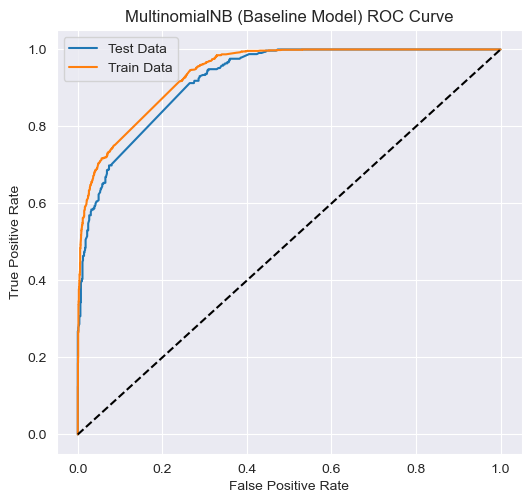

In [163]:
display_results('MultinomialNB (Baseline Model)', 'Email-Subject', pipe_baseline, X_train, y_train, X_test, y_test)

ANALYSIS:
- Pretty good for minimal baseline processing with maximum training FPR=1%; Precision=0.92, Accuracy=0.86
- Nearly half of the Spam goes to Ham, but more importantly only 16 (2%) Ham goes to Spam
- The baseline accuracy on the test set is better than the training cross-val score, so not overfitted

---

---


### Naive Bayes GridSearchCV for Email-Subject with CountVectorizer
- We'll get the best params for a gridsearch on Naive Bayes for the Email-Subject
- Optimized for Accuracy at this stage, we will add these classifications to a column in the Email-Body features

In [164]:
pipe_nb_clf = pipe_baseline

nb_grid = {'count_vec__max_features': [500],#2500, 3000, 3500],
           'count_vec__min_df': [1, 3, 5],
           'count_vec__max_df': [0.80, 0.85, 0.9],
           'count_vec__binary': [True, False],
           'count_vec__stop_words': [None, stop_words],
           'count_vec__tokenizer': [regexp_tokenizer, word_punct_tokenizer],
           'baseline_clf__alpha': [0.5, 1.0, 2.0, 2.5],
           'baseline_clf__fit_prior': [True, False]}


# Set up the grid search
nb_grid_search = GridSearchCV(pipe_nb_clf, nb_grid, cv=5, scoring='precision', n_jobs=-1)

# Fit the grid search
nb_grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", nb_grid_search.best_params_)
print("Best precision score: ", nb_grid_search.best_score_)

Best parameters found:  {'baseline_clf__alpha': 2.5, 'baseline_clf__fit_prior': True, 'count_vec__binary': True, 'count_vec__max_df': 0.8, 'count_vec__max_features': 500, 'count_vec__min_df': 3, 'count_vec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 

Model: MultinomialNB | CountVectorizer Gridsearch
                 Recall: 0.6325
                     F1: 0.7143
                    AUC: 0.7879
         Train Accuracy: 0.8729
               Accuracy: 0.8531
              Precision: 0.8203
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       812
           1       0.82      0.63      0.71       332

    accuracy                           0.85      1144
   macro avg       0.84      0.79      0.81      1144
weighted avg       0.85      0.85      0.85      1144



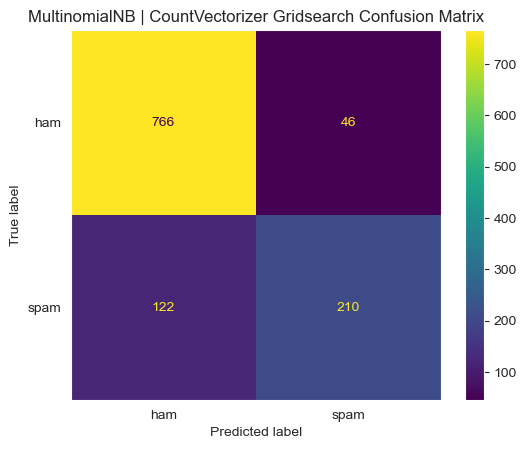

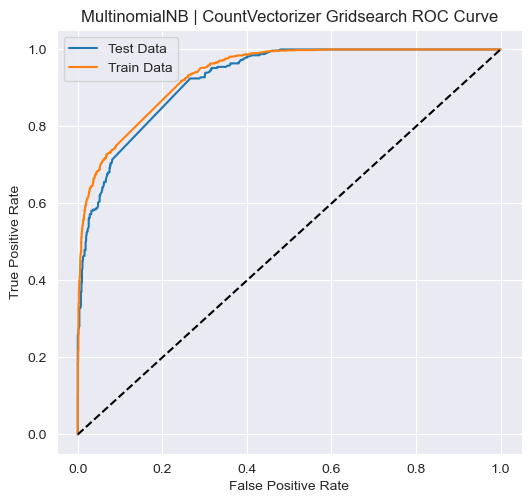

In [165]:
display_results('MultinomialNB | CountVectorizer Gridsearch', 
                'Email-Subject', 
                nb_grid_search.best_estimator_, 
                X_train, y_train, X_test, y_test)

In [166]:
get_sorted_results()

,Model Name,Data Set,Recall,F1,AUC,Train Accuracy,Accuracy,Precision
1,MultinomialNB | CountVectorizer Gridsearch,Email-Subject,0.632530,0.714286,0.787940,0.872922,0.853147,0.820312
0,MultinomialNB (Baseline Model),Email-Subject,0.644578,0.721754,0.793348,0.878171,0.855769,0.819923


ANALYSIS:
- Count vectorized is slightly better precision but in the noise probably.
- Makes sense as the subject line is usually pretty sparse on words, so counts will not be much different than binary values

---

### Naive Bayes GridSearchCV for Email-Subject with TF-IDF Vectorizer
- We'll get the best params for a gridsearch on Naive Bayes for the Email-Subject
- Optimized for Accuracy at this stage, we will add these classifications to a column in the Email-Body features

In [167]:
step_tf_vec = ('tf_vec', TfidfVectorizer())

pipe_nb_tf_clf = Pipeline([step_tf_vec, step_baseline_model])

nb_tf_grid = {'tf_vec__max_features': [500],#2500, 3000, 3500],
              'tf_vec__min_df': [1, 3, 5],
              'tf_vec__max_df': [0.80, 0.85, 0.9],
              'tf_vec__stop_words': [None, stop_words],
              'tf_vec__tokenizer': [regexp_tokenizer, word_punct_tokenizer],
              'baseline_clf__alpha': [0.5, 1.0, 2.0, 2.5],
              'baseline_clf__fit_prior': [True, False]}



# Set up the grid search
nb_tf_grid_search = GridSearchCV(pipe_nb_tf_clf, nb_tf_grid, cv=5, scoring='precision', n_jobs=-1)

# Fit the grid search
nb_tf_grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", nb_tf_grid_search.best_params_)


Best parameters found:  {'baseline_clf__alpha': 2.5, 'baseline_clf__fit_prior': True, 'tf_vec__max_df': 0.8, 'tf_vec__max_features': 500, 'tf_vec__min_df': 5, 'tf_vec__stop_words': None, 'tf_vec__tokenizer': <function word_punct_tokenizer at 0x000001B07C2BB9D0>}


Model: MultinomialNB | TF-IDF Vectorizer Gridsearch
                 Recall: 0.7018
                     F1: 0.7966
                    AUC: 0.8386
         Train Accuracy: 0.9007
               Accuracy: 0.8960
              Precision: 0.9209
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       812
           1       0.92      0.70      0.80       332

    accuracy                           0.90      1144
   macro avg       0.90      0.84      0.86      1144
weighted avg       0.90      0.90      0.89      1144



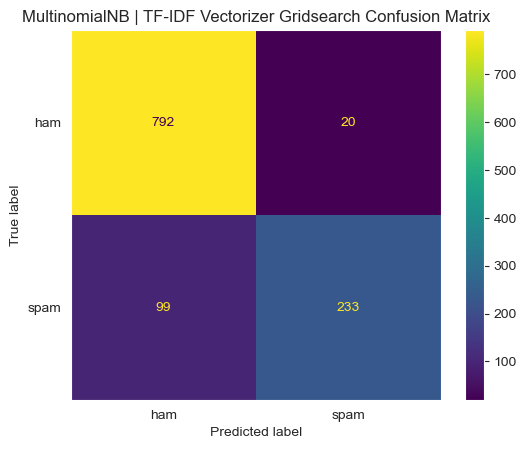

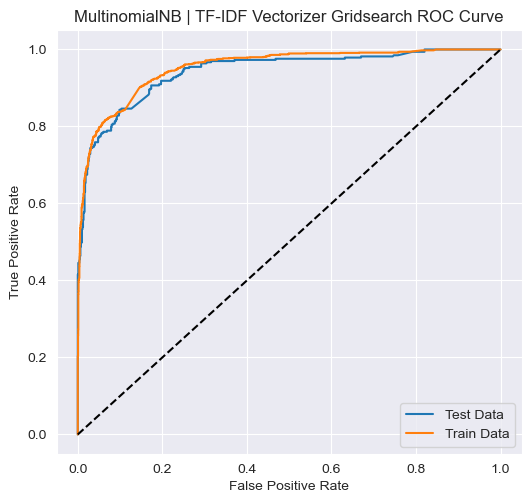

In [168]:
display_results('MultinomialNB | TF-IDF Vectorizer Gridsearch', 
                'Email-Subject', 
                nb_tf_grid_search.best_estimator_, 
                X_train, y_train, X_test, y_test)

In [169]:
get_sorted_results()

,Model Name,Data Set,Recall,F1,AUC,Train Accuracy,Accuracy,Precision
2,MultinomialNB | TF-IDF Vectorizer Gridsearch,Email-Subject,0.701807,0.796581,0.838588,0.900700,0.895979,0.920949
1,MultinomialNB | CountVectorizer Gridsearch,Email-Subject,0.632530,0.714286,0.787940,0.872922,0.853147,0.820312
0,MultinomialNB (Baseline Model),Email-Subject,0.644578,0.721754,0.793348,0.878171,0.855769,0.819923


---

---

## Email-Body


### Cleaning and EDA

In [170]:
# Create a copy of the subject dataframe for EDA 
body_eda_df = body_df.copy()

# Lowercase the subject column
body_eda_df['body'] = body_eda_df['body'].apply(lambda x: str.lower(x))

# Tokenize the subject column
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
body_eda_df['body_tokenized'] = body_eda_df['body'].apply(lambda x: tokenizer.tokenize(x))


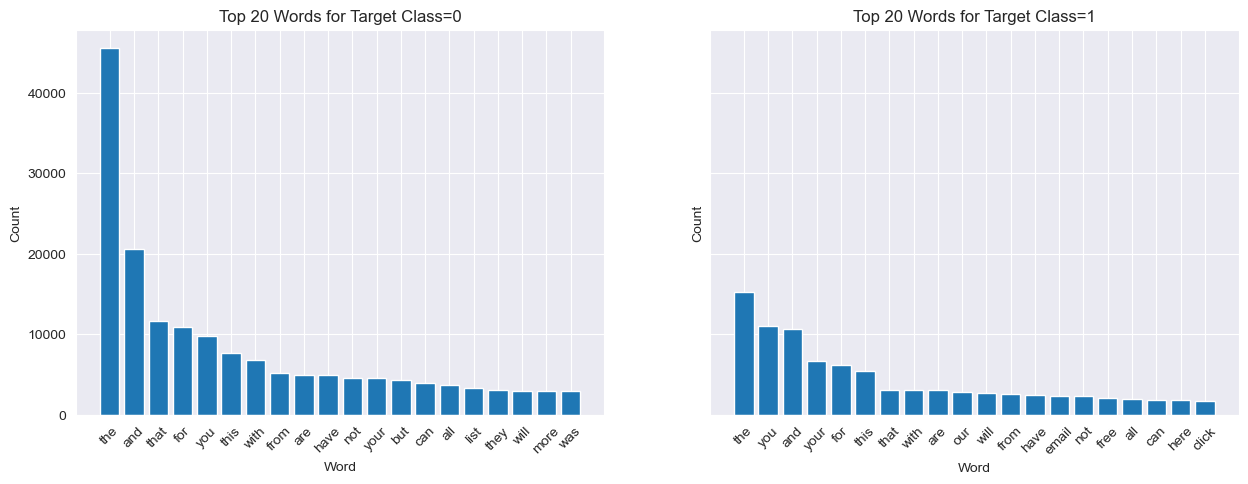

In [171]:
# visualize the top 20 words in the subject column for spam and not spam
histogram_top_n_words(body_eda_df, 20, 'body_tokenized', 'target')

ANALYSYS:
- Mostly stopwords that we will remove.
- Digits are interesting, we will account for them in an engineererd feature
- We don't readily see the occurrance of 'Cheat words' like we did in the subject line

In [172]:
body_eda_df['body_tokenized'] = body_eda_df['body_tokenized'].apply(lambda x: remove_stopwords(x, stop_words))
               

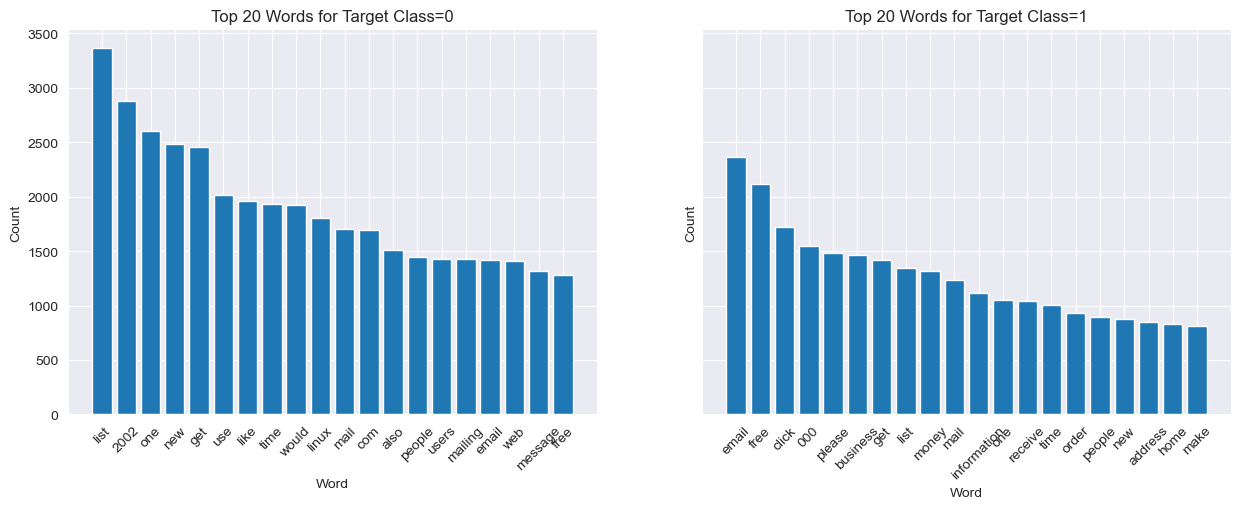

In [173]:
# visualize the top 20 words in the subject with stopwords removed
histogram_top_n_words(body_eda_df, 20, 'body_tokenized', 'target')

ANALYSIS:
- Looks like a pretty clean and realistic representation of the classes now

---

## Preprocessing and Modeling

In [174]:
# Create our train and test sets
X_body = body_df['body']
y_body = body_df['target']

X_train_body, X_test_body, y_train_body, y_test_body = train_test_split(X_body, y_body, test_size=0.2, random_state=42)

---
### Baseline Model:
- Basic tokenizer of >2 characters
- Binary vectorizer
- Multinomial Bayes Classifier

In [175]:
# Create the baseline basic binary CountVectorizer pipeline step tuple
step_count_vec = ('count_vec', CountVectorizer(max_features=500,
                                                min_df=2,
                                                max_df=0.95,
                                                binary=True, 
                                                stop_words=stop_words, 
                                                tokenizer=regexp_tokenizer))

# Create the baseline MultinomialNB pipeline step tuple
step_baseline_model = ('baseline_clf', MultinomialNB(fit_prior=True))

# Create and fit the pipeline for the baseline model
pipe_baseline = Pipeline([step_count_vec, step_baseline_model])

pipe_baseline.fit(X_train_body, y_train_body)

Pipeline(steps=[('count_vec',
                 CountVectorizer(binary=True, max_df=0.95, max_features=500,
                                 min_df=2,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function regexp_tokenizer at 0x000001B07C2BB040>)),
                ('baseline_clf', MultinomialNB())])

Model: MultinomialNB (Baseline)
                 Recall: 0.8855
                     F1: 0.8829
                    AUC: 0.9181
         Train Accuracy: 0.9423
               Accuracy: 0.9318
              Precision: 0.8802
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       812
           1       0.88      0.89      0.88       332

    accuracy                           0.93      1144
   macro avg       0.92      0.92      0.92      1144
weighted avg       0.93      0.93      0.93      1144



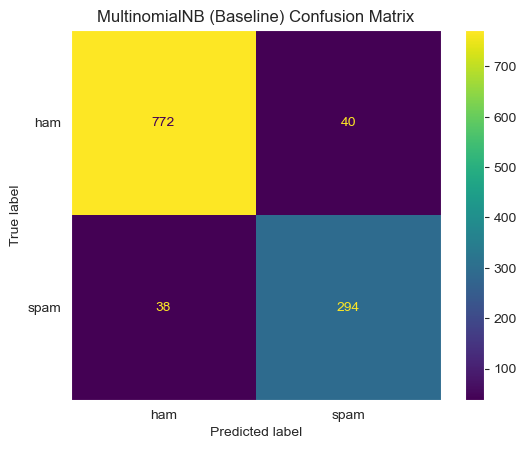

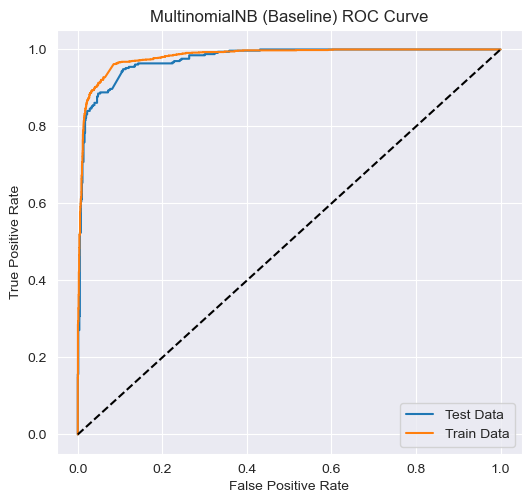

In [176]:
display_results('MultinomialNB (Baseline)', 'Email-Body', pipe_baseline, X_train_body, y_train_body, X_test_body, y_test_body)

In [177]:
get_sorted_results()

,Model Name,Data Set,Recall,F1,AUC,Train Accuracy,Accuracy,Precision
3,MultinomialNB (Baseline),Email-Body,0.885542,0.882883,0.918141,0.942257,0.931818,0.880240
2,MultinomialNB | TF-IDF Vectorizer Gridsearch,Email-Subject,0.701807,0.796581,0.838588,0.900700,0.895979,0.920949
1,MultinomialNB | CountVectorizer Gridsearch,Email-Subject,0.632530,0.714286,0.787940,0.872922,0.853147,0.820312
0,MultinomialNB (Baseline Model),Email-Subject,0.644578,0.721754,0.793348,0.878171,0.855769,0.819923


ANALYSIS:
- Wow, very nice results right out of the gate for baseline model using only tokenized, stopword removed NB!

---

## Feature Engineering
- look at counts of various features within the raw texts, ie punctuation ratios, digit ratios, etc
- add in the subject line probability predictions as a column

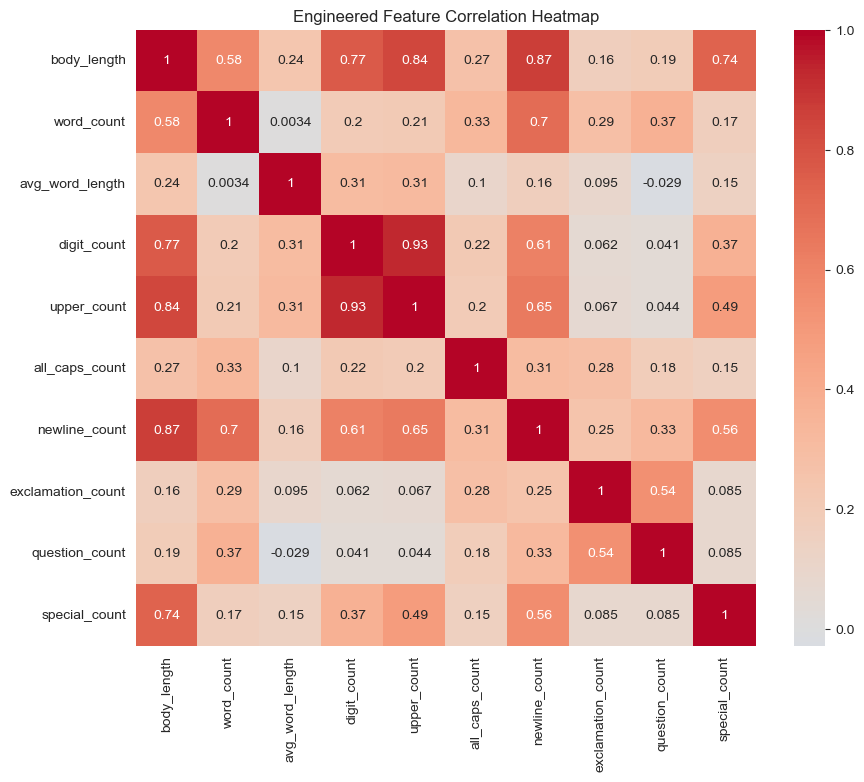

In [178]:
# Create a deep copy of X_body preserving the column names
X_body_eng = body_df.drop('target', axis=1).copy()

# Add a column to the dataframe that contains the length of the email body
X_body_eng['body_length'] = X_body_eng['body'].apply(len)
# Add a column to the dataframe that contains the number of words in the email body
X_body_eng['word_count'] = X_body_eng['body'].apply(lambda x: len(x.split()))
# Add a column to the dataframe that contains the average word length in the email body
X_body_eng['avg_word_length'] = X_body_eng['body'].apply(lambda x: np.mean([len(word) for word in x.split()]))
# Add a column to the dataframe that contains the number of digits in the email body
X_body_eng['digit_count'] = X_body_eng['body'].apply(lambda x: len(re.findall(r'\d', x)))
# Add a column to the dataframe that contains the number of uppercase letters in the email body
X_body_eng['upper_count'] = X_body_eng['body'].apply(lambda x: len(re.findall(r'[A-Z]', x)))
# Add a column to the dataframe that contains the number of words in all caps in the email body
X_body_eng['all_caps_count'] = X_body_eng['body'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
# Add a column to the dataframe that contains the number of newlines in the email body
X_body_eng['newline_count'] = X_body_eng['body'].apply(lambda x: len(re.findall(r'\n', x)))
# Add a column to the dataframe that contains the number of exclamation points in the email body
X_body_eng['exclamation_count'] = X_body_eng['body'].apply(lambda x: len(re.findall(r'!', x)))
# Add a column to the dataframe that contains the number of question marks in the email body
X_body_eng['question_count'] = X_body_eng['body'].apply(lambda x: len(re.findall(r'\?', x)))
# Add a column to the dataframe that contains the number special characters that didn't match any of the other columns
X_body_eng['special_count'] = X_body_eng['body'].apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', x)))

X_body_eng.drop('body', axis=1, inplace=True)

# Create a correlation heatmap of the new features
show_corr_heatmap(X_body_eng, 'Engineered Feature Correlation Heatmap')

ANALYSIS:
- Looks like body_length is correlated with a few items, and we should probably normalize all the other features by body length anyway.

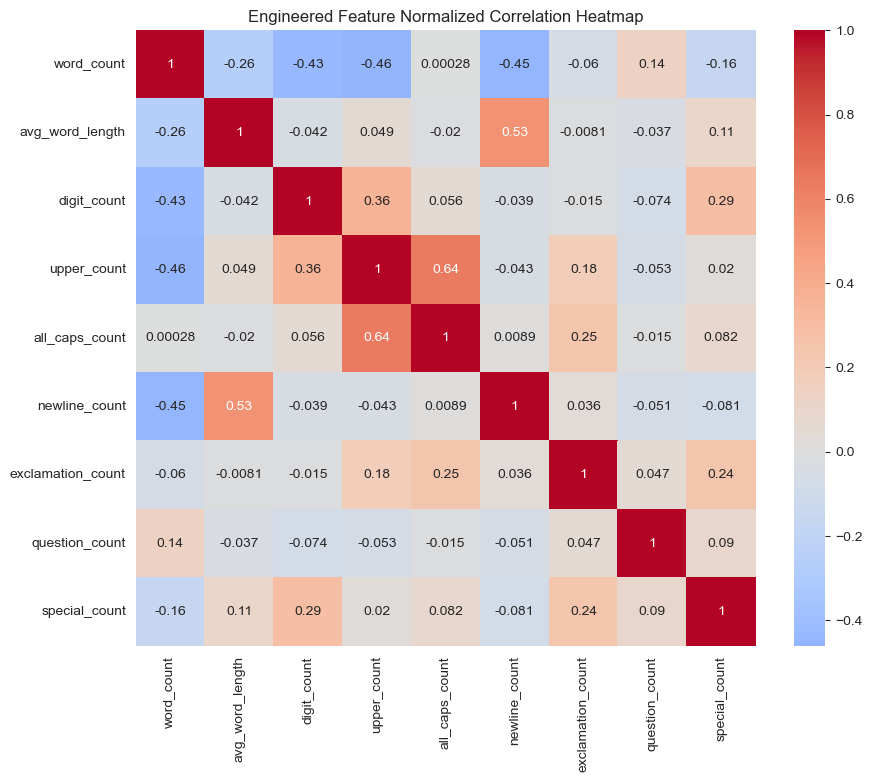

In [179]:
# Normalize all the features by body_length
X_body_eng_norm = X_body_eng.div(X_body_eng['body_length'], axis=0)
X_body_eng_norm.drop('body_length', axis=1, inplace=True)
# concatenate the subject line predicted probabilities to the normalized features


subject_pred_prob = nb_tf_grid_search.best_estimator_.predict_proba(X_train)


# Create a correlation heatmap of the new features
show_corr_heatmap(X_body_eng_norm, 'Engineered Feature Normalized Correlation Heatmap')


ANALYSIS:
- This looks better, few correlated features.  
- all_caps_count vs upper_count is still creeping high but I want to keep it for now as there might be a signal in caps_count (i.e. do Ham vs Spam tend to not capitalize the first word in a sentence more often)

### NOTE OF CONCERN: I plan on concatenating the feature engineering with various vectorizations of the body tokens, so will need to take care of how the models react to the two differently normalized datasets

In [180]:
# function that finds the row in model_results_df that has the best precision for the email subject
def get_best_subject_predict_proba(X):
    best_subject_precision = model_results_df[(model_results_df['Data Set'] == 'Email-Subject') & 
                                            (model_results_df['Precision'] == model_results_df[model_results_df['Data Set'] == 'Email-Subject']['Precision'].max())]
    best_subject_model = best_subject_precision['Best Estimator'].values[0]
    return best_subject_model.predict_proba(X)[:,1]

# concatenate the subject line predicted probabilities to the normalized features
X_body_eng_norm['subject_predict_proba'] = get_best_subject_predict_proba(X)

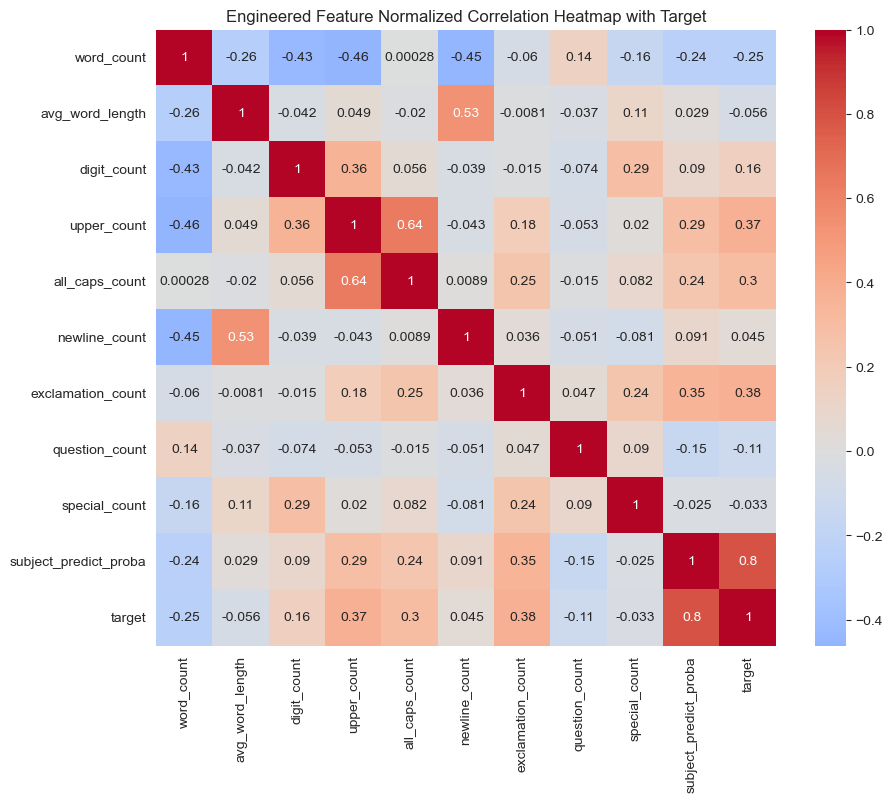

In [181]:
# Concatenate the target column to the normalized features and check the correlations
X_body_eng_norm['target'] = y_body
show_corr_heatmap(X_body_eng_norm, 'Engineered Feature Normalized Correlation Heatmap with Target')

    ANALYSIS:
- Not very high correlations in our engineered features to the target but might be a signal in a few of them(upper count, all caps count, exclamation count)
- very little correlation in avg word length, newline count, question count and special count, lets drop those.
- Our subject line Ham v Spam predictions are highly correlated to the target; this should boost the classification accuracy for the body classifiers

### NOTE OF CONCERN: I plan on concatenating the feature engineering with various vectorizations of the body tokens, so will need to take care of how the models react to the two differently normalized datasets

In [182]:
# dropping engineered features that have a correlation with the target less than +/-0.1
X_body_eng_norm.drop(['avg_word_length', 'newline_count', 'special_count'], axis=1, inplace=True)

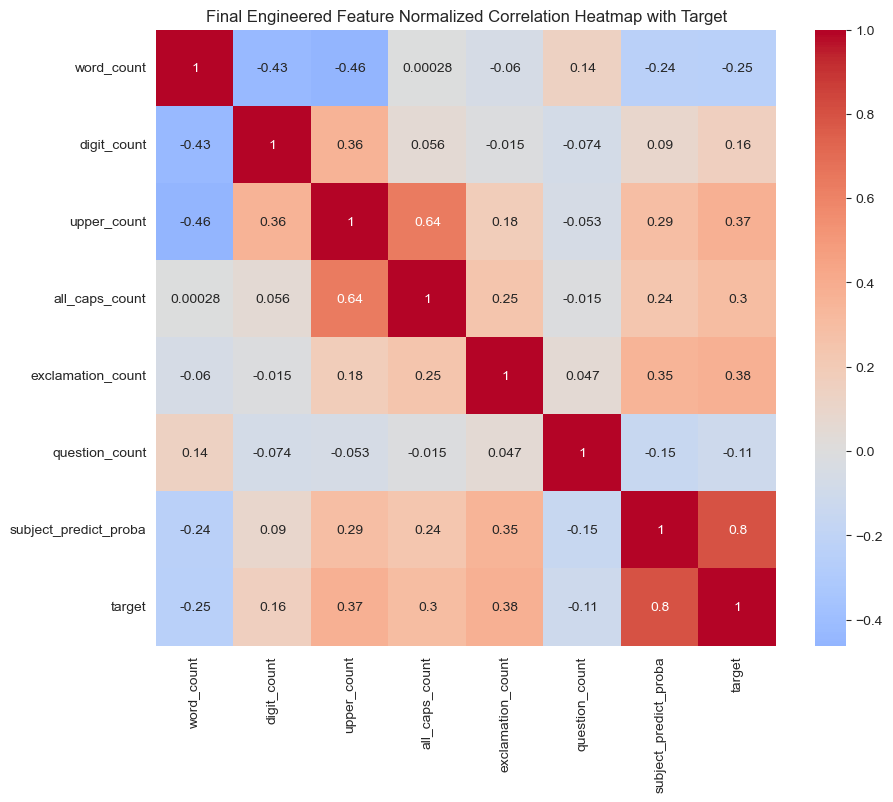

In [183]:
show_corr_heatmap(X_body_eng_norm, 'Final Engineered Feature Normalized Correlation Heatmap with Target')

In [184]:
# Create a class to be used in our preprocessing pipeline that returns the engineered features

def feat_eng_transform(X):

    X_eng = pd.DataFrame(X, columns=['body'])
    
    # Add a column to the dataframe that contains the length of the email body
    body_length = X_eng['body'].apply(len)
    body_length = 1  # Normalize by 1 to keep the original values
    # Add a column to the dataframe that contains the number of words in the email body
    X_eng['word_count'] = X_eng['body'].apply(lambda x: len(x.split())) / body_length
    # Add a column to the dataframe that contains the number of digits in the email body
    X_eng['digit_count'] = X_eng['body'].apply(lambda x: len(re.findall(r'\d', x))) / body_length
    # Add a column to the dataframe that contains the number of uppercase letters in the email body
    X_eng['upper_count'] = X_eng['body'].apply(lambda x: len(re.findall(r'[A-Z]', x))) / body_length
    # Add a column to the dataframe that contains the number of words in all caps in the email body
    X_eng['all_caps_count'] = X_eng['body'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x))) / body_length
    # Add a column to the dataframe that contains the number of exclamation points in the email body
    X_eng['exclamation_count'] = X_eng['body'].apply(lambda x: len(re.findall(r'!', x))) / body_length
    # Add a column to the dataframe that contains the number of question marks in the email body
    X_eng['question_count'] = X_eng['body'].apply(lambda x: len(re.findall(r'\?', x))) / body_length
    # Add a column to the dataframe that contains the subject line predicted probabilities
    X_eng['subject_predict_proba'] = get_best_subject_predict_proba(X_eng['body'])

    return X_eng.drop('body', axis=1)
    



---


---
### Baseline Model with Engineered Features Added:
- Basic tokenizer of >2 characters
- Binary vectorizer
- Engineered Features
- Multinomial Bayes Classifier

In [185]:
# Create the baseline basic binary CountVectorizer pipeline step tuple

# the X data needs to be in a DataFrame for the ColumnTransformer
X_train_body = pd.DataFrame(X_train_body, columns=['body'])
X_test_body = pd.DataFrame(X_test_body, columns=['body'])

feature_eng = ColumnTransformer(transformers=[
        ("nlp_feat_eng", FunctionTransformer(feat_eng_transform), ["body"])
    ], remainder="drop")


count_vec = ColumnTransformer(
    transformers=[
        ('count_vec', CountVectorizer(max_features=500,
                                        min_df=2,
                                        max_df=0.95,
                                        binary=True, 
                                        stop_words=stop_words, 
                                        tokenizer=regexp_tokenizer), 'body')
    ], remainder='drop')



feature_union = FeatureUnion(transformer_list=[
        ("vectorized_features", count_vec),
        ("engineered_features", feature_eng)
    ])


pipeline = Pipeline([
    ('preprocessing', feature_union),
    step_baseline_model
])

pipeline.fit(X_train_body, y_train_body)


Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('vectorized_features',
                                                 ColumnTransformer(transformers=[('count_vec',
                                                                                  CountVectorizer(binary=True,
                                                                                                  max_df=0.95,
                                                                                                  max_features=500,
                                                                                                  min_df=2,
                                                                                                  stop_words=['i',
                                                                                                              'me',
                                                                                                              'my',
                                                                                                              'myself',
                                                                                                              'we',
                                                                                                              'our',
                                                                                                              'ours',
                                                                                                              'ourselves',
                                                                                                              'you',
                                                                                                              "you're",
                                                                                                              "you've",
                                                                                                              "you'll",
                                                                                                              "you'd",
                                                                                                              'your',
                                                                                                              'yours',
                                                                                                              'yourself',
                                                                                                              'yourselves',
                                                                                                              'he',
                                                                                                              'h...
                                                                                                              'his',
                                                                                                              'himself',
                                                                                                              'she',
                                                                                                              "she's",
                                                                                                              'her',
                                                                                                              'hers',
                                                                                                              'herself',
                                                                                                              'it',
                                                                                                              "it's",
                                     

Model: MultinomialNB | Feature Eng
                 Recall: 0.2289
                     F1: 0.3628
                    AUC: 0.6077
         Train Accuracy: 0.7660
               Accuracy: 0.7666
              Precision: 0.8736
              precision    recall  f1-score   support

           0       0.76      0.99      0.86       812
           1       0.87      0.23      0.36       332

    accuracy                           0.77      1144
   macro avg       0.82      0.61      0.61      1144
weighted avg       0.79      0.77      0.71      1144



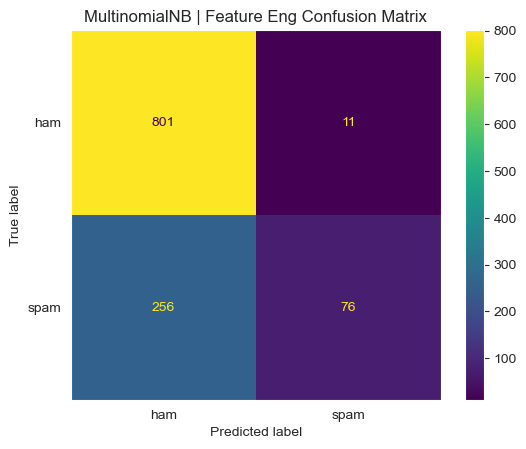

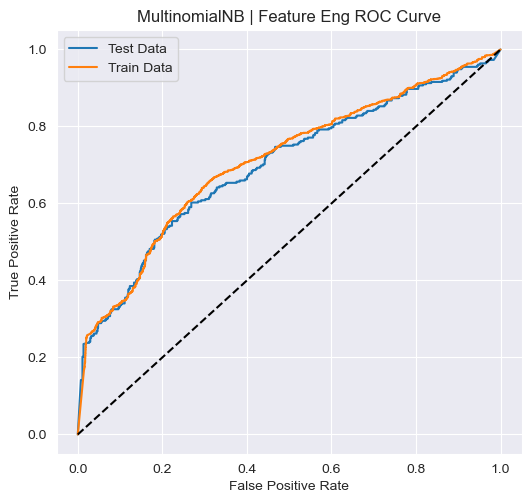

In [186]:
display_results('MultinomialNB | Feature Eng', 'Email-Body', pipeline, X_train_body, y_train_body, X_test_body, y_test_body)

In [187]:
get_sorted_results()

,Model Name,Data Set,Recall,F1,AUC,Train Accuracy,Accuracy,Precision
3,MultinomialNB (Baseline),Email-Body,0.885542,0.882883,0.918141,0.942257,0.931818,0.880240
4,MultinomialNB | Feature Eng,Email-Body,0.228916,0.362768,0.607684,0.765967,0.766608,0.873563
2,MultinomialNB | TF-IDF Vectorizer Gridsearch,Email-Subject,0.701807,0.796581,0.838588,0.900700,0.895979,0.920949
1,MultinomialNB | CountVectorizer Gridsearch,Email-Subject,0.632530,0.714286,0.787940,0.872922,0.853147,0.820312
0,MultinomialNB (Baseline Model),Email-Subject,0.644578,0.721754,0.793348,0.878171,0.855769,0.819923


    ANALYSIS:
- Amazing! Our brilliant feature engineering actually made the model worse! Perhaps normalizing after the union will help

---
### MultinomialNB | Feature_eng normalized | BinaryVectorized

In [188]:
feat_eng_transform(X_test_body)

,word_count,digit_count,upper_count,all_caps_count,exclamation_count,question_count,subject_predict_proba
2954,112.0,0.0,18.0,0.0,3.0,0.0,0.982728
2873,221.0,55.0,86.0,11.0,5.0,0.0,0.984882
4325,215.0,30.0,77.0,7.0,0.0,1.0,0.385998
1163,420.0,55.0,256.0,37.0,3.0,4.0,0.831203
4424,28.0,6.0,13.0,1.0,0.0,0.0,0.154227
...,...,...,...,...,...,...,...
5023,334.0,20.0,39.0,3.0,0.0,3.0,0.521677
1281,1393.0,273.0,518.0,49.0,3.0,11.0,0.630299
1400,106.0,2.0,15.0,0.0,2.0,0.0,0.744198
803,326.0,84.0,158.0,22.0,9.0,0.0,0.814048


In [189]:
# Create the baseline basic binary CountVectorizer pipeline step tuple

# column transformer for the engineered features and then normalizing them
feature_eng = ColumnTransformer(transformers=[
        ("nlp_feat_eng", FunctionTransformer(feat_eng_transform), ["body"]),
    ], remainder="drop")

feat_eng_scaler = StandardScaler(with_mean=False)

feat_eng_pipe = Pipeline([
    ('preprocessing', feature_eng),
    ('scaler', feat_eng_scaler),
])


count_vec = ColumnTransformer(
    transformers=[
        ('count_vec', CountVectorizer(max_features=500,
                                        min_df=2,
                                        max_df=0.95,
                                        binary=True, 
                                        stop_words=stop_words, 
                                        tokenizer=regexp_tokenizer), 'body')
    ], remainder='drop')


feature_union = FeatureUnion(transformer_list=[
        ("vectorized_features", count_vec),
        ("engineered_features", feat_eng_pipe)
    ])


pipeline = Pipeline([
    ('preprocessing', feature_union),
    step_baseline_model
])

pipeline.fit(X_train_body, y_train_body)



Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('vectorized_features',
                                                 ColumnTransformer(transformers=[('count_vec',
                                                                                  CountVectorizer(binary=True,
                                                                                                  max_df=0.95,
                                                                                                  max_features=500,
                                                                                                  min_df=2,
                                                                                                  stop_words=['i',
                                                                                                              'me',
                                                                                                              'my',
                                                                                                              'myself',
                                                                                                              'we',
                                                                                                              'our',
                                                                                                              'ours',
                                                                                                              'ourselves',
                                                                                                              'you',
                                                                                                              "you're",
                                                                                                              "you've",
                                                                                                              "you'll",
                                                                                                              "you'd",
                                                                                                              'your',
                                                                                                              'yours',
                                                                                                              'yourself',
                                                                                                              'yourselves',
                                                                                                              'he',
                                                                                                              'h...
                                                                                                              'itself', ...],
                                                                                                  tokenizer=<function regexp_tokenizer at 0x000001B07C2BB040>),
                                                                                  'body')])),
                                                ('engineered_features',
                                                 Pipeline(steps=[('preprocessing',
                                                                  ColumnTransformer(transformers=[('nlp_feat_eng',
                                                                                                   FunctionTransformer(func=<function feat_eng_transform at 0x000001B0022BF8B0>),
                                                                                                   ['body'])])),
                                                                 ('scaler',
                                                                  StandardScaler(wit

Model: MultinomialNB | Feature_eng normalized | BinaryVectorized
                 Recall: 0.9398
                     F1: 0.8902
                    AUC: 0.9348
         Train Accuracy: 0.9440
               Accuracy: 0.9327
              Precision: 0.8455
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       812
           1       0.85      0.94      0.89       332

    accuracy                           0.93      1144
   macro avg       0.91      0.93      0.92      1144
weighted avg       0.94      0.93      0.93      1144



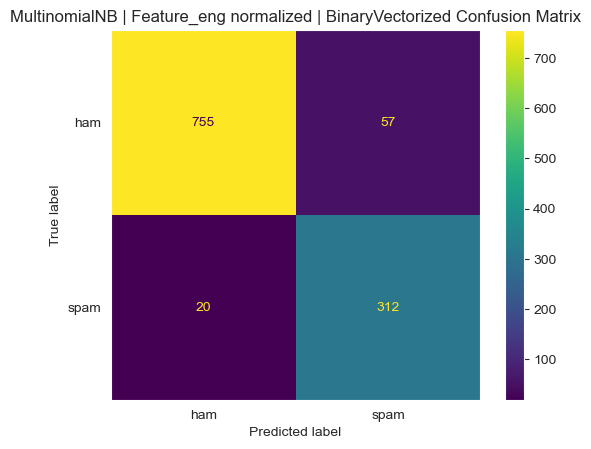

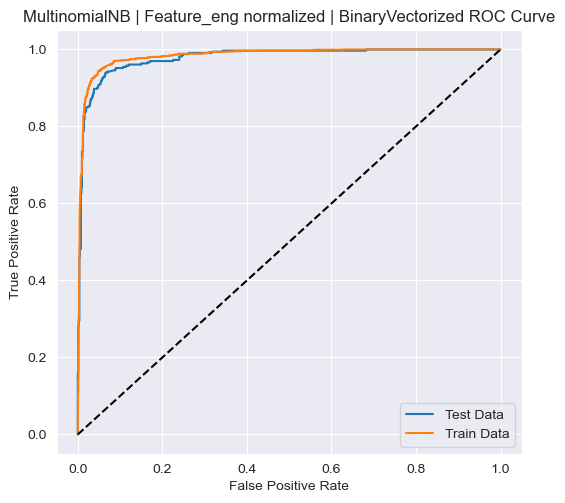

In [190]:
display_results('MultinomialNB | Feature_eng normalized | BinaryVectorized', 'Email-Body', pipeline, X_train_body, y_train_body, X_test_body, y_test_body)

In [191]:
get_sorted_results()

,Model Name,Data Set,Recall,F1,AUC,Train Accuracy,Accuracy,Precision
3,MultinomialNB (Baseline),Email-Body,0.885542,0.882883,0.918141,0.942257,0.931818,0.880240
4,MultinomialNB | Feature Eng,Email-Body,0.228916,0.362768,0.607684,0.765967,0.766608,0.873563
5,MultinomialNB | Feature_eng normalized | Binar...,Email-Body,0.939759,0.890157,0.934781,0.944007,0.932692,0.845528
2,MultinomialNB | TF-IDF Vectorizer Gridsearch,Email-Subject,0.701807,0.796581,0.838588,0.900700,0.895979,0.920949
1,MultinomialNB | CountVectorizer Gridsearch,Email-Subject,0.632530,0.714286,0.787940,0.872922,0.853147,0.820312
0,MultinomialNB (Baseline Model),Email-Subject,0.644578,0.721754,0.793348,0.878171,0.855769,0.819923


    ANALYSIS:
- Amazing! Our brilliant feature engineering actually made the model worse! Perhaps normalizing after the union will help

---
### Baseline Model with Engineered Features and Normalization:
- Basic tokenizer of >2 characters
- Binary vectorizer
- Engineered Features
- StandardScaler()
- Multinomial Bayes Classifier

In [192]:
step_ss_X = ('ss_X', StandardScaler(with_mean=False))

pipeline = Pipeline([
    ('preprocessing', feature_union),
    step_ss_X,
    step_baseline_model
])

pipeline.fit(X_train_body, y_train_body)

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('vectorized_features',
                                                 ColumnTransformer(transformers=[('count_vec',
                                                                                  CountVectorizer(binary=True,
                                                                                                  max_df=0.95,
                                                                                                  max_features=500,
                                                                                                  min_df=2,
                                                                                                  stop_words=['i',
                                                                                                              'me',
                                                                                                              'my',
                                                                                                              'myself',
                                                                                                              'we',
                                                                                                              'our',
                                                                                                              'ours',
                                                                                                              'ourselves',
                                                                                                              'you',
                                                                                                              "you're",
                                                                                                              "you've",
                                                                                                              "you'll",
                                                                                                              "you'd",
                                                                                                              'your',
                                                                                                              'yours',
                                                                                                              'yourself',
                                                                                                              'yourselves',
                                                                                                              'he',
                                                                                                              'h...
                                                                                                  tokenizer=<function regexp_tokenizer at 0x000001B07C2BB040>),
                                                                                  'body')])),
                                                ('engineered_features',
                                                 Pipeline(steps=[('preprocessing',
                                                                  ColumnTransformer(transformers=[('nlp_feat_eng',
                                                                                                   FunctionTransformer(func=<function feat_eng_transform at 0x000001B0022BF8B0>),
                                                                                                   ['body'])])),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))])),
                ('ss_X', StandardScaler(with_mean=False)),
                ('baseline_clf', MultinomialN

Model: MulitnomialNB | Feature Eng | StandardScaler
                 Recall: 0.9277
                     F1: 0.8813
                    AUC: 0.9275
         Train Accuracy: 0.9390
               Accuracy: 0.9274
              Precision: 0.8392
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       812
           1       0.84      0.93      0.88       332

    accuracy                           0.93      1144
   macro avg       0.90      0.93      0.91      1144
weighted avg       0.93      0.93      0.93      1144



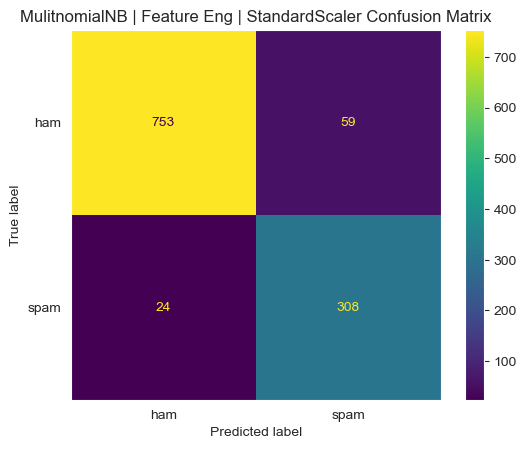

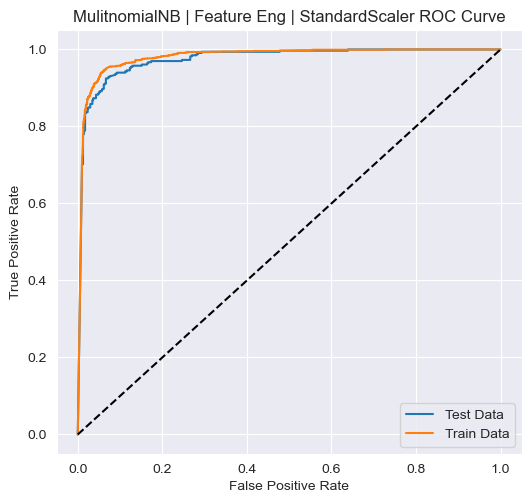

In [193]:
display_results('MulitnomialNB | Feature Eng | StandardScaler', 'Email-Body', pipeline, X_train_body, y_train_body, X_test_body, y_test_body)

In [194]:
get_sorted_results()

,Model Name,Data Set,Recall,F1,AUC,Train Accuracy,Accuracy,Precision
3,MultinomialNB (Baseline),Email-Body,0.885542,0.882883,0.918141,0.942257,0.931818,0.880240
4,MultinomialNB | Feature Eng,Email-Body,0.228916,0.362768,0.607684,0.765967,0.766608,0.873563
5,MultinomialNB | Feature_eng normalized | Binar...,Email-Body,0.939759,0.890157,0.934781,0.944007,0.932692,0.845528
6,MulitnomialNB | Feature Eng | StandardScaler,Email-Body,0.927711,0.881259,0.927525,0.938976,0.927448,0.839237
2,MultinomialNB | TF-IDF Vectorizer Gridsearch,Email-Subject,0.701807,0.796581,0.838588,0.900700,0.895979,0.920949
1,MultinomialNB | CountVectorizer Gridsearch,Email-Subject,0.632530,0.714286,0.787940,0.872922,0.853147,0.820312
0,MultinomialNB (Baseline Model),Email-Subject,0.644578,0.721754,0.793348,0.878171,0.855769,0.819923


    ANALYSIS:
- Worse precision than without normalization, but slightly better accuracy

---
### MultinomialNB,Engineered Features, Normalization Gridsearch:
- Basic tokenizer of >2 characters
- Binary vectorizer
- Engineered Features
- gridsearch standardscalar, absmaxscaler, robustscalar
- Multinomial Bayes Classifier

In [195]:

pipeline = Pipeline([
    ('preprocessing', feature_union),
    step_ss_X,
    step_baseline_model
])

grid = {'ss_X': [StandardScaler(with_mean=False), MaxAbsScaler(), RobustScaler(with_centering=False)]}

grid_search = GridSearchCV(pipeline, grid, cv=5, scoring='precision')
grid_search.fit(X_train_body, y_train_body)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        FeatureUnion(transformer_list=[('vectorized_features',
                                                                        ColumnTransformer(transformers=[('count_vec',
                                                                                                         CountVectorizer(binary=True,
                                                                                                                         max_df=0.95,
                                                                                                                         max_features=500,
                                                                                                                         min_df=2,
                                                                                                                         stop_words=['i',
                                                                                                                                     'me',
                                                                                                                                     'my',
                                                                                                                                     'myself',
                                                                                                                                     'we',
                                                                                                                                     'our',
                                                                                                                                     'ours',
                                                                                                                                     'ourselves',
                                                                                                                                     'you',
                                                                                                                                     "you're",
                                                                                                                                     "you've",
                                                                                                                                     "you'll",
                                                                                                                                     "you'd",
                                                                                                                                     'your',
                                                                                                                                     'yours',
                                                                                                                                     'yo...
                                                                                         ColumnTransformer(transformers=[('nlp_feat_eng',
                                                                                                                          FunctionTransformer(func=<function feat_eng_transform at 0x000001B0022BF8B0>),
                                                                                                                          ['body'])])),
                                                                                        ('scaler',
                                                                                         StandardScaler(with_mean=False))]))])),
                                       ('ss_X',
                                        StandardScaler(with_mean=False)),
                                       ('baseline_clf', MultinomialNB())]),
             

In [196]:
grid_search.best_params_

{'ss_X': RobustScaler(with_centering=False)}

Model: MultinomialNB | Feature Eng | Normalizer Gridsearch
                 Recall: 0.8946
                     F1: 0.8932
                    AUC: 0.9251
         Train Accuracy: 0.9414
               Accuracy: 0.9379
              Precision: 0.8919
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       812
           1       0.89      0.89      0.89       332

    accuracy                           0.94      1144
   macro avg       0.92      0.93      0.92      1144
weighted avg       0.94      0.94      0.94      1144



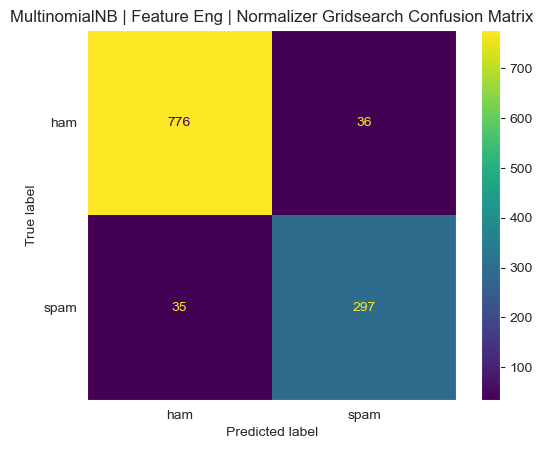

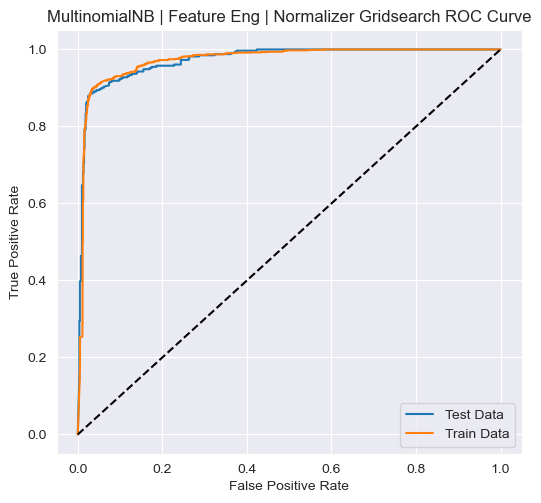

In [197]:
display_results('MultinomialNB | Feature Eng | Normalizer Gridsearch', 'Email-Body', grid_search.best_estimator_, X_train_body, y_train_body, X_test_body, y_test_body)

In [198]:
get_sorted_results()

,Model Name,Data Set,Recall,F1,AUC,Train Accuracy,Accuracy,Precision
7,MultinomialNB | Feature Eng | Normalizer Grids...,Email-Body,0.894578,0.893233,0.925122,0.941382,0.937937,0.891892
3,MultinomialNB (Baseline),Email-Body,0.885542,0.882883,0.918141,0.942257,0.931818,0.880240
4,MultinomialNB | Feature Eng,Email-Body,0.228916,0.362768,0.607684,0.765967,0.766608,0.873563
5,MultinomialNB | Feature_eng normalized | Binar...,Email-Body,0.939759,0.890157,0.934781,0.944007,0.932692,0.845528
6,MulitnomialNB | Feature Eng | StandardScaler,Email-Body,0.927711,0.881259,0.927525,0.938976,0.927448,0.839237
2,MultinomialNB | TF-IDF Vectorizer Gridsearch,Email-Subject,0.701807,0.796581,0.838588,0.900700,0.895979,0.920949
1,MultinomialNB | CountVectorizer Gridsearch,Email-Subject,0.632530,0.714286,0.787940,0.872922,0.853147,0.820312
0,MultinomialNB (Baseline Model),Email-Subject,0.644578,0.721754,0.793348,0.878171,0.855769,0.819923


    ANALYSIS:
- MaxAbsScaler() was the best, but only slightly better than standard scalar and still not as good as the baseline model.

---
### MultinomialNB | Eng_feat Normalized | TF-IDF Vector:

In [199]:

tf_idf_vec = ColumnTransformer(
    transformers=[
        ('tf_idf_vec', TfidfVectorizer(max_features=500,
                                        min_df=2,
                                        max_df=0.95,
                                        stop_words=stop_words, 
                                        tokenizer=regexp_tokenizer), 'body')
    ], remainder='drop')


feature_union = FeatureUnion(transformer_list=[
        ("vectorized_features", tf_idf_vec),
        ("engineered_features", feat_eng_pipe)
    ])

pipeline = Pipeline([
    ('preprocessing', feature_union),
    step_baseline_model
])


pipeline.fit(X_train_body, y_train_body)



Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('vectorized_features',
                                                 ColumnTransformer(transformers=[('tf_idf_vec',
                                                                                  TfidfVectorizer(max_df=0.95,
                                                                                                  max_features=500,
                                                                                                  min_df=2,
                                                                                                  stop_words=['i',
                                                                                                              'me',
                                                                                                              'my',
                                                                                                              'myself',
                                                                                                              'we',
                                                                                                              'our',
                                                                                                              'ours',
                                                                                                              'ourselves',
                                                                                                              'you',
                                                                                                              "you're",
                                                                                                              "you've",
                                                                                                              "you'll",
                                                                                                              "you'd",
                                                                                                              'your',
                                                                                                              'yours',
                                                                                                              'yourself',
                                                                                                              'yourselves',
                                                                                                              'he',
                                                                                                              'him',
                                                                                                              'his',
                                                                                                              '...
                                                                                                              'itself', ...],
                                                                                                  tokenizer=<function regexp_tokenizer at 0x000001B07C2BB040>),
                                                                                  'body')])),
                                                ('engineered_features',
                                                 Pipeline(steps=[('preprocessing',
                                                                  ColumnTransformer(transformers=[('nlp_feat_eng',
                                                                                                   FunctionTransformer(func=<function feat_eng_transform at 0x000001B0022BF8B0>),
                                                                                                   ['body'])])),
                                     

Model: MultinomialNB | Eng_feat Normalized | TF-IDF Vector
                 Recall: 0.8946
                     F1: 0.9041
                    AUC: 0.9300
         Train Accuracy: 0.9538
               Accuracy: 0.9449
              Precision: 0.9138
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       812
           1       0.91      0.89      0.90       332

    accuracy                           0.94      1144
   macro avg       0.94      0.93      0.93      1144
weighted avg       0.94      0.94      0.94      1144



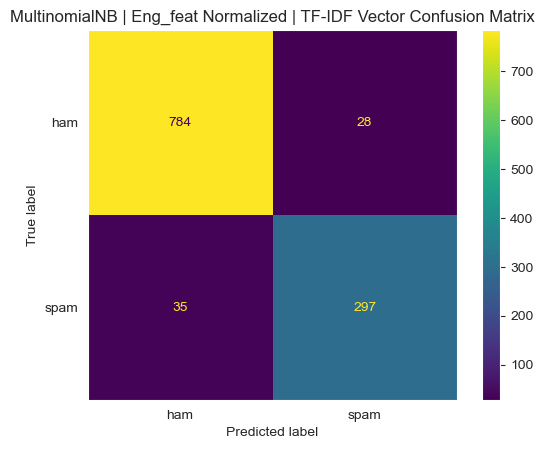

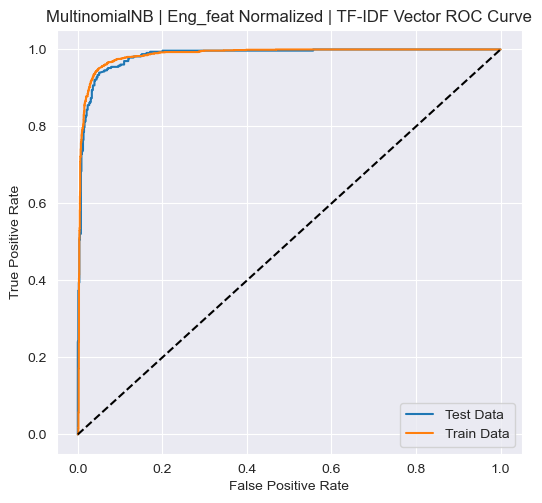

In [202]:
display_results('MultinomialNB | Eng_feat Normalized | TF-IDF Vector', 'Email-Body', pipeline, X_train_body, y_train_body, X_test_body, y_test_body)

In [203]:
get_sorted_results()

,Model Name,Data Set,Recall,F1,AUC,Train Accuracy,Accuracy,Precision
8,MultinomialNB | Eng_feat Normalized | TF-IDF V...,Email-Body,0.894578,0.904110,0.930048,0.953850,0.944930,0.913846
7,MultinomialNB | Feature Eng | Normalizer Grids...,Email-Body,0.894578,0.893233,0.925122,0.941382,0.937937,0.891892
3,MultinomialNB (Baseline),Email-Body,0.885542,0.882883,0.918141,0.942257,0.931818,0.880240
4,MultinomialNB | Feature Eng,Email-Body,0.228916,0.362768,0.607684,0.765967,0.766608,0.873563
5,MultinomialNB | Feature_eng normalized | Binar...,Email-Body,0.939759,0.890157,0.934781,0.944007,0.932692,0.845528
6,MulitnomialNB | Feature Eng | StandardScaler,Email-Body,0.927711,0.881259,0.927525,0.938976,0.927448,0.839237
2,MultinomialNB | TF-IDF Vectorizer Gridsearch,Email-Subject,0.701807,0.796581,0.838588,0.900700,0.895979,0.920949
1,MultinomialNB | CountVectorizer Gridsearch,Email-Subject,0.632530,0.714286,0.787940,0.872922,0.853147,0.820312
0,MultinomialNB (Baseline Model),Email-Subject,0.644578,0.721754,0.793348,0.878171,0.855769,0.819923


---
### MultinomialNB_fpr_capped | Eng_feat Normalized | TF-IDF Vector

In [210]:

tf_idf_vec = ColumnTransformer(
    transformers=[
        ('tf_idf_vec', TfidfVectorizer(max_features=500,
                                        min_df=2,
                                        max_df=0.95,
                                        stop_words=stop_words, 
                                        tokenizer=regexp_tokenizer), 'body')
    ], remainder='drop')


feature_union = FeatureUnion(transformer_list=[
        ("vectorized_features", tf_idf_vec),
        ("engineered_features", feat_eng_pipe)
    ])

step_multiNB_fpr_capped = ('multiNB_fpr_capped', ThresholdAdjuster(MultinomialNB(fit_prior=True), max_fpr=0.01))

pipeline = Pipeline([
    ('preprocessing', feature_union),
    step_multiNB_fpr_capped
])


pipeline.fit(X_train_body, y_train_body)



Threshold: 0.762, FPR: 0.010


Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('vectorized_features',
                                                 ColumnTransformer(transformers=[('tf_idf_vec',
                                                                                  TfidfVectorizer(max_df=0.95,
                                                                                                  max_features=500,
                                                                                                  min_df=2,
                                                                                                  stop_words=['i',
                                                                                                              'me',
                                                                                                              'my',
                                                                                                              'myself',
                                                                                                              'we',
                                                                                                              'our',
                                                                                                              'ours',
                                                                                                              'ourselves',
                                                                                                              'you',
                                                                                                              "you're",
                                                                                                              "you've",
                                                                                                              "you'll",
                                                                                                              "you'd",
                                                                                                              'your',
                                                                                                              'yours',
                                                                                                              'yourself',
                                                                                                              'yourselves',
                                                                                                              'he',
                                                                                                              'him',
                                                                                                              'his',
                                                                                                              '...
                                                                                                  tokenizer=<function regexp_tokenizer at 0x000001B07C2BB040>),
                                                                                  'body')])),
                                                ('engineered_features',
                                                 Pipeline(steps=[('preprocessing',
                                                                  ColumnTransformer(transformers=[('nlp_feat_eng',
                                                                                                   FunctionTransformer(func=<function feat_eng_transform at 0x000001B0022BF8B0>),
                                                                                                   ['body'])])),
                                                                 ('scaler',
                                                                  StandardScaler(with_m

Model: MultinomialNB_fpr_capped | Eng_feat Normalized | TF-IDF Vector
                 Recall: 0.7711
                     F1: 0.8548
                    AUC: 0.8788
         Train Accuracy: 0.9298
               Accuracy: 0.9240
              Precision: 0.9588
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       812
           1       0.96      0.77      0.85       332

    accuracy                           0.92      1144
   macro avg       0.94      0.88      0.90      1144
weighted avg       0.93      0.92      0.92      1144



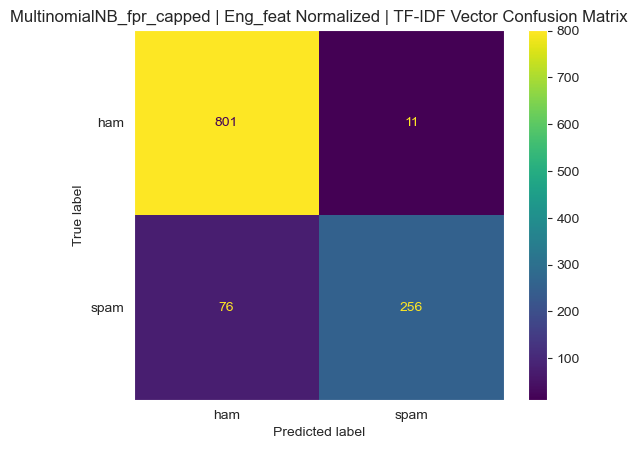

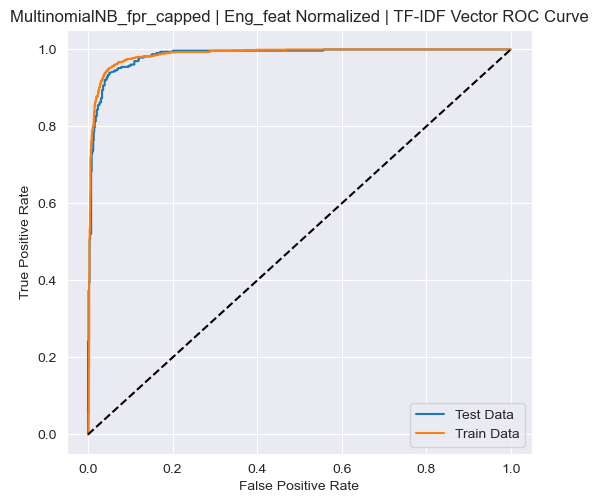

In [211]:
display_results('MultinomialNB_fpr_capped | Eng_feat Normalized | TF-IDF Vector', 'Email-Body', pipeline, X_train_body, y_train_body, X_test_body, y_test_body)

In [212]:
get_sorted_results()

,Model Name,Data Set,Recall,F1,AUC,Train Accuracy,Accuracy,Precision
9,MultinomialNB_fpr_capped | Eng_feat Normalized...,Email-Body,0.771084,0.854758,0.878769,0.929790,0.923951,0.958801
8,MultinomialNB | Eng_feat Normalized | TF-IDF V...,Email-Body,0.894578,0.904110,0.930048,0.953850,0.944930,0.913846
7,MultinomialNB | Feature Eng | Normalizer Grids...,Email-Body,0.894578,0.893233,0.925122,0.941382,0.937937,0.891892
3,MultinomialNB (Baseline),Email-Body,0.885542,0.882883,0.918141,0.942257,0.931818,0.880240
4,MultinomialNB | Feature Eng,Email-Body,0.228916,0.362768,0.607684,0.765967,0.766608,0.873563
5,MultinomialNB | Feature_eng normalized | Binar...,Email-Body,0.939759,0.890157,0.934781,0.944007,0.932692,0.845528
6,MulitnomialNB | Feature Eng | StandardScaler,Email-Body,0.927711,0.881259,0.927525,0.938976,0.927448,0.839237
2,MultinomialNB | TF-IDF Vectorizer Gridsearch,Email-Subject,0.701807,0.796581,0.838588,0.900700,0.895979,0.920949
1,MultinomialNB | CountVectorizer Gridsearch,Email-Subject,0.632530,0.714286,0.787940,0.872922,0.853147,0.820312
0,MultinomialNB (Baseline Model),Email-Subject,0.644578,0.721754,0.793348,0.878171,0.855769,0.819923


---
### MultinomialNB | Eng_feat Normalized | TF-IDF Vector | Gridsearch:

In [ ]:

tf_idf_vec = ColumnTransformer(
    transformers=[
        ('tf_idf_vec', TfidfVectorizer(max_features=500,
                                        min_df=2,
                                        max_df=0.95,
                                        stop_words=stop_words, 
                                        tokenizer=regexp_tokenizer), 'body')
    ], remainder='drop')


feature_union = FeatureUnion(transformer_list=[
        ("vectorized_features", tf_idf_vec),
        ("engineered_features", feat_eng_pipe)
    ])

clf = MultinomialNB(fit_prior=True)
step_multiNB_fpr_capped = ('multiNB_fpr_capped', ThresholdAdjuster(clf, max_fpr=0.01))

pipeline = Pipeline([
    ('preprocessing', feature_union),
    step_multiNB_fpr_capped
])

# grid = {'multiNB_fpr_capped__base_estimator__alpha': [0.01, 1, 10, 100],
#         'preprocessing__vectorized_features__tf_idf_vec__max_features': [500, 1000, 1500, 2000],
#         'preprocessing__vectorized_features__tf_idf_vec__min_df': [1, 3, 5],
#         'preprocessing__vectorized_features__tf_idf_vec__max_df': [0.80, 0.85, 0.90],
#         'preprocessing__vectorized_features__tf_idf_vec__tokenizer': [regexp_tokenizer, word_punct_tokenizer]}


# grid_search = GridSearchCV(pipeline, grid, cv=5, scoring='precision')

# grid_search.fit(X_train_body, y_train_body)



In [218]:
grid_search.best_params_
# {'multiNB_fpr_capped__base_estimator__alpha': 10,
#  'preprocessing__vectorized_features__tf_idf_vec__max_df': 0.8,
#  'preprocessing__vectorized_features__tf_idf_vec__max_features': 1500,
#  'preprocessing__vectorized_features__tf_idf_vec__min_df': 1,
#  'preprocessing__vectorized_features__tf_idf_vec__tokenizer': <function __main__.word_punct_tokenizer(text)>}

{'multiNB_fpr_capped__base_estimator__alpha': 10,
 'preprocessing__vectorized_features__tf_idf_vec__max_df': 0.8,
 'preprocessing__vectorized_features__tf_idf_vec__max_features': 1500,
 'preprocessing__vectorized_features__tf_idf_vec__min_df': 1,
 'preprocessing__vectorized_features__tf_idf_vec__tokenizer': <function __main__.word_punct_tokenizer(text)>}

Model: MultinomialNB | Eng_feat Normalized | TF-IDF Vector | Gridsearch
                 Recall: 0.7139
                     F1: 0.8215
                    AUC: 0.8520
         Train Accuracy: 0.9197
               Accuracy: 0.9100
              Precision: 0.9673
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       812
           1       0.97      0.71      0.82       332

    accuracy                           0.91      1144
   macro avg       0.93      0.85      0.88      1144
weighted avg       0.92      0.91      0.91      1144



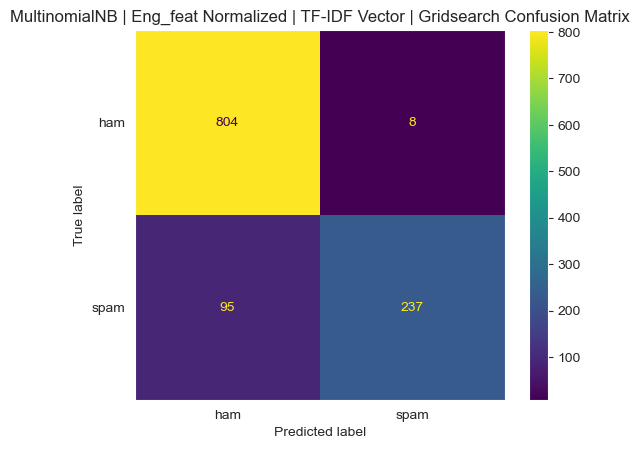

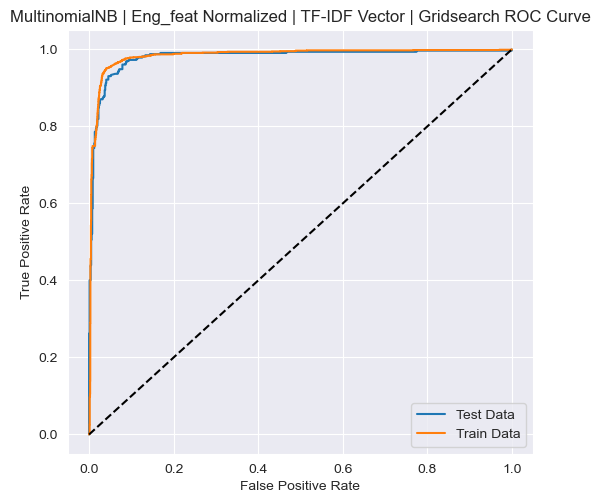

In [219]:
display_results('MultinomialNB_fpr_capped | Eng_feat Normalized | TF-IDF Vector | Gridsearch', 'Email-Body', grid_search.best_estimator_, X_train_body, y_train_body, X_test_body, y_test_body)

In [220]:
get_sorted_results()

,Model Name,Data Set,Recall,F1,AUC,Train Accuracy,Accuracy,Precision
10,MultinomialNB | Eng_feat Normalized | TF-IDF V...,Email-Body,0.713855,0.821490,0.852002,0.919729,0.909965,0.967347
9,MultinomialNB_fpr_capped | Eng_feat Normalized...,Email-Body,0.771084,0.854758,0.878769,0.929790,0.923951,0.958801
8,MultinomialNB | Eng_feat Normalized | TF-IDF V...,Email-Body,0.894578,0.904110,0.930048,0.953850,0.944930,0.913846
7,MultinomialNB | Feature Eng | Normalizer Grids...,Email-Body,0.894578,0.893233,0.925122,0.941382,0.937937,0.891892
3,MultinomialNB (Baseline),Email-Body,0.885542,0.882883,0.918141,0.942257,0.931818,0.880240
4,MultinomialNB | Feature Eng,Email-Body,0.228916,0.362768,0.607684,0.765967,0.766608,0.873563
5,MultinomialNB | Feature_eng normalized | Binar...,Email-Body,0.939759,0.890157,0.934781,0.944007,0.932692,0.845528
6,MulitnomialNB | Feature Eng | StandardScaler,Email-Body,0.927711,0.881259,0.927525,0.938976,0.927448,0.839237
2,MultinomialNB | TF-IDF Vectorizer Gridsearch,Email-Subject,0.701807,0.796581,0.838588,0.900700,0.895979,0.920949
1,MultinomialNB | CountVectorizer Gridsearch,Email-Subject,0.632530,0.714286,0.787940,0.872922,0.853147,0.820312


---
### MultinomialNB | Eng_feat Normalized | TF-IDF Vector | Gridsearch:

In [235]:

# Ensure that the required NLTK data is downloaded
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def pos_tokenizer(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Perform POS tagging
    tagged_tokens = nltk.pos_tag(tokens)
    return tagged_tokens



tf_idf_vec = ColumnTransformer(
    transformers=[
        ('tf_idf_vec', TfidfVectorizer(max_features=500,
                                        min_df=2,
                                        max_df=0.95,
                                        stop_words=stop_words, 
                                        tokenizer=regexp_tokenizer), 'body')
    ], remainder='drop')


feature_union = FeatureUnion(transformer_list=[
        ("vectorized_features", tf_idf_vec),
        ("engineered_features", feat_eng_pipe)
    ])

clf = MultinomialNB(fit_prior=True)
step_multiNB_fpr_capped = ('multiNB_fpr_capped', ThresholdAdjuster(clf, max_fpr=0.01))

pipeline = Pipeline([
    ('preprocessing', feature_union),
    step_multiNB_fpr_capped
])


# grid = {'multiNB_fpr_capped__base_estimator__alpha': [0.01, 1, 10, 100],
#         'preprocessing__vectorized_features__tf_idf_vec__max_features': [500, 1000, 1500, 2000],
#         'preprocessing__vectorized_features__tf_idf_vec__min_df': [1, 3, 5],
#         'preprocessing__vectorized_features__tf_idf_vec__max_df': [0.80, 0.85, 0.90],
#         'preprocessing__vectorized_features__tf_idf_vec__tokenizer': [regexp_tokenizer, word_punct_tokenizer]}


#grid_search.best_params_  FIRST RUN
# {'multiNB_fpr_capped__base_estimator__alpha': 10,
#  'preprocessing__vectorized_features__tf_idf_vec__max_df': 0.8,
#  'preprocessing__vectorized_features__tf_idf_vec__max_features': 1500,
#  'preprocessing__vectorized_features__tf_idf_vec__min_df': 1,
#  'preprocessing__vectorized_features__tf_idf_vec__tokenizer': <function __main__.word_punct_tokenizer(text)>}

grid = {'multiNB_fpr_capped__base_estimator__alpha': [10],
        'preprocessing__vectorized_features__tf_idf_vec__max_features': [1500],
        'preprocessing__vectorized_features__tf_idf_vec__min_df': [1],
        'preprocessing__vectorized_features__tf_idf_vec__max_df': [0.80],
        'preprocessing__vectorized_features__tf_idf_vec__tokenizer': [word_punct_tokenizer, pos_tokenizer]}

grid_search = GridSearchCV(pipeline, grid, cv=5, scoring='precision')

grid_search.fit(X_train_body, y_train_body)

# BEST PARAM RESULTS
# {'multiNB_fpr_capped__base_estimator__alpha': 10,
#  'preprocessing__vectorized_features__tf_idf_vec__max_df': 0.8,
#  'preprocessing__vectorized_features__tf_idf_vec__max_features': 1500,
#  'preprocessing__vectorized_features__tf_idf_vec__min_df': 1,
#  'preprocessing__vectorized_features__tf_idf_vec__tokenizer': <function __main__.word_punct_tokenizer(text)>}

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\daled\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\daled\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Threshold: 0.686, FPR: 0.009
Threshold: 0.650, FPR: 0.009
Threshold: 0.720, FPR: 0.006
Threshold: 0.671, FPR: 0.007
Threshold: 0.648, FPR: 0.009
Threshold: 0.655, FPR: 0.010
Threshold: 0.674, FPR: 0.009
Threshold: 0.651, FPR: 0.009
Threshold: 0.646, FPR: 0.010
Threshold: 0.662, FPR: 0.010
Threshold: 0.705, FPR: 0.009


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        FeatureUnion(transformer_list=[('vectorized_features',
                                                                        ColumnTransformer(transformers=[('tf_idf_vec',
                                                                                                         TfidfVectorizer(max_df=0.95,
                                                                                                                         max_features=500,
                                                                                                                         min_df=2,
                                                                                                                         stop_words=['i',
                                                                                                                                     'me',
                                                                                                                                     'my',
                                                                                                                                     'myself',
                                                                                                                                     'we',
                                                                                                                                     'our',
                                                                                                                                     'ours',
                                                                                                                                     'ourselves',
                                                                                                                                     'you',
                                                                                                                                     "you're",
                                                                                                                                     "you've",
                                                                                                                                     "you'll",
                                                                                                                                     "you'd",
                                                                                                                                     'your',
                                                                                                                                     'yours',
                                                                                                                                     'yourself',
                                                                                                                                     'yo...
                         'preprocessing__vectorized_features__tf_idf_vec__max_df': [0.8],
                         'preprocessing__vectorized_features__tf_idf_vec__max_features': [1500],
                         'preprocessing__vectorized_features__tf_idf_vec__min_df': [1],
                         'preprocessing__vectorized_features__tf_idf_vec__tokenizer': [<function word_punct_tokenizer at 0x000001B07C2BB9D0>,
                                                                                       <function pos_tokenizer at 0x000001B01210ED30>]},
             scoring='precision')

In [237]:
grid_search.best_params_

{'multiNB_fpr_capped__base_estimator__alpha': 10,
 'preprocessing__vectorized_features__tf_idf_vec__max_df': 0.8,
 'preprocessing__vectorized_features__tf_idf_vec__max_features': 1500,
 'preprocessing__vectorized_features__tf_idf_vec__min_df': 1,
 'preprocessing__vectorized_features__tf_idf_vec__tokenizer': <function __main__.word_punct_tokenizer(text)>}

Model: NB_fpr_capped | ... | Search tokenizer
                 Recall: 0.7139
                     F1: 0.8215
                    AUC: 0.8520
         Train Accuracy: 0.9197
               Accuracy: 0.9100
              Precision: 0.9673
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       812
           1       0.97      0.71      0.82       332

    accuracy                           0.91      1144
   macro avg       0.93      0.85      0.88      1144
weighted avg       0.92      0.91      0.91      1144



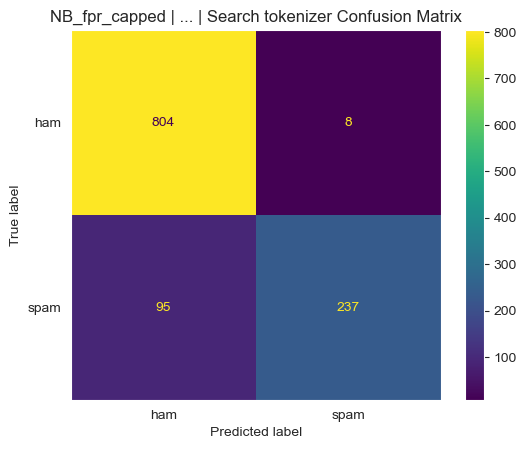

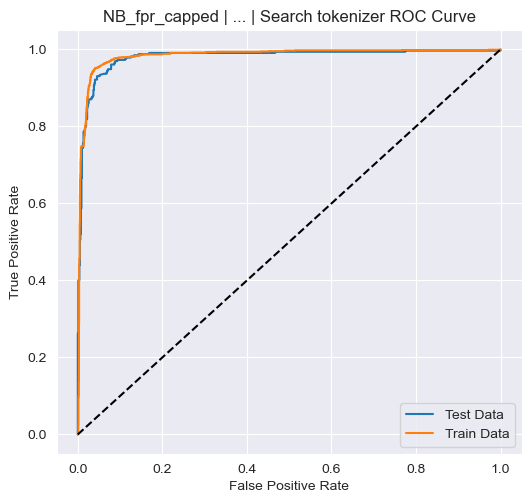

In [238]:
display_results('NB_fpr_capped | ... | Search tokenizer', 'Email-Body', grid_search.best_estimator_, X_train_body, y_train_body, X_test_body, y_test_body)

In [239]:
get_sorted_results()

,Model Name,Data Set,Recall,F1,AUC,Train Accuracy,Accuracy,Precision
10,MultinomialNB | Eng_feat Normalized | TF-IDF V...,Email-Body,0.713855,0.821490,0.852002,0.919729,0.909965,0.967347
11,NB_fpr_capped | Eng_feat Normalized | TF-IDF V...,Email-Body,0.713855,0.821490,0.852002,0.919729,0.909965,0.967347
12,NB_fpr_capped | ... | Search tokenizer,Email-Body,0.713855,0.821490,0.852002,0.919729,0.909965,0.967347
9,MultinomialNB_fpr_capped | Eng_feat Normalized...,Email-Body,0.771084,0.854758,0.878769,0.929790,0.923951,0.958801
8,MultinomialNB | Eng_feat Normalized | TF-IDF V...,Email-Body,0.894578,0.904110,0.930048,0.953850,0.944930,0.913846
7,MultinomialNB | Feature Eng | Normalizer Grids...,Email-Body,0.894578,0.893233,0.925122,0.941382,0.937937,0.891892
3,MultinomialNB (Baseline),Email-Body,0.885542,0.882883,0.918141,0.942257,0.931818,0.880240
4,MultinomialNB | Feature Eng,Email-Body,0.228916,0.362768,0.607684,0.765967,0.766608,0.873563
5,MultinomialNB | Feature_eng normalized | Binar...,Email-Body,0.939759,0.890157,0.934781,0.944007,0.932692,0.845528
6,MulitnomialNB | Feature Eng | StandardScaler,Email-Body,0.927711,0.881259,0.927525,0.938976,0.927448,0.839237
